# TODO:

In [1]:
import os
import glob
import cmocean
import h5py as h5
import numpy as np
import healpy as hp
import pandas as pd
import splotch as sp
import cmocean as cmo
import matplotlib.cm as cm
import scipy.optimize as opti
import matplotlib.colors as col
import matplotlib.lines as lines
import matplotlib.pyplot as plot
import matplotlib.gridspec as gs
import scipy.interpolate as interp
import matplotlib.patches as patches
from IPython.display import display, Markdown
from matplotlib.legend_handler import HandlerTuple
%matplotlib inline

In [2]:
sp.use_style('/home/mbravo/Documents/pypati.style')
new_fig_size=np.array(plot.rcParams.get('figure.figsize'))
col_map=cm.get_cmap(cmo.cm.haline)
zlist=['z015','z045','z075','z105','z185']

# Defining functions

### E(B-V) to filters

In [3]:
def extinction_law(ebv,band_1,band_2):
    R={'u_ap':4.37,'g_ap':3.31,'r_ap':2.32,'i_ap':1.72,'z_ap':1.28}
    A1=R[band_1]*ebv
    A2=R[band_2]*ebv
    E=A1-A2
    
    return(A1,E)

### Metric measurement

In [4]:
def slope_func(dust_comp,ebvmap,dusted=False):
    if dusted:
        dust_comp['deltaEBV']=dust_comp['EBV']
        temp=dust_comp.loc[dust_comp['deltaEBV']<0.1]
    else:
        dust_comp['deltaEBV']=dust_comp['EBV']-np.median(ebvmap)
        temp=dust_comp.loc[(dust_comp['deltaEBV']>-0.05)&(dust_comp['deltaEBV']<0.05)]
    max_debv=temp['deltaEBV']==np.max(temp['deltaEBV'])
    min_debv=temp['deltaEBV']==np.min(temp['deltaEBV'])
    cen_debv=np.abs(temp['deltaEBV'])==np.min(np.abs(temp['deltaEBV']))
    
    md=(float(temp.loc[max_debv,'delta'])-float(temp.loc[min_debv,'delta']))/0.1
    mm=(float(temp.loc[max_debv,'mag'])-float(temp.loc[min_debv,'mag']))/0.1
    mc=(float(temp.loc[max_debv,'col'])-float(temp.loc[min_debv,'col']))/0.1
    
    dust_comp['delta']-=np.mean(temp.loc[cen_debv,'delta'])
    dust_comp['mag']-=np.mean(temp.loc[cen_debv,'mag'])
    dust_comp['col']-=np.mean(temp.loc[cen_debv,'col'])
    
    return(dust_comp,md,mm,mc)

### $E(B-V)$ recovery

In [5]:
def map_recovery(ns,dust_table,pixel_data,zrange=[[0.0,0.3],[0.3,0.6],[0.6,0.9],[0.9,1.2],[1.2,2.5]]):
    nside_key=f'n{ns}'
    #Debv,ebv_from_delta,ebv_from_mag,ebv_from_col=[],[],[],[]
    Debv,ebv_from_mag,ebv_from_col=[],[],[]
    EBV_recovery,z_label=[],[]
    EBV_input=pixel_data[f'{nside_key}_EBV']
    for j in range(len(zrange)):
        zr=zrange[j]
        z_label.append(f'$z_{{{np.sum(zr)/2:.2f}}}$')
        z_key=f'z{np.sum(zr)/2:.2f}'.replace('.','')
        
        ####################
        # Delta calc
        ####################
        #delta=pixel_data[f'{nside_key}_{z_key}_count']+np.random.uniform(-0.5,0.5,len(pixel_data))
        #pixel_data[f'{nside_key}_{z_key}_delta']=np.log10(delta/np.mean(delta))
        
        ####################
        # Read dust vector
        ####################
        dust_vector=dust_table[z_key]
        dust_vector,ebv2d,ebv2m,ebv2c=slope_func(dust_vector,np.array(pixel_data[f'{nside_key}_EBV']))
        
        Debv.append(pixel_data[f'{nside_key}_EBV']-np.median(pixel_data[f'{nside_key}_EBV']))
        #ebv_from_delta.append((pixel_data[f'{nside_key}_{z_key}_delta']-np.median(pixel_data[f'{nside_key}_{z_key}_delta']))/ebv2d)
        ebv_from_mag.append((pixel_data[f'{nside_key}_{z_key}_mag']-np.median(pixel_data[f'{nside_key}_{z_key}_mag']))/ebv2m)
        ebv_from_col.append((pixel_data[f'{nside_key}_{z_key}_col']-np.median(pixel_data[f'{nside_key}_{z_key}_col']))/ebv2c)
        
        #spl_delta=interp.UnivariateSpline(dust_vector['deltaEBV'],dust_vector['delta'],ext=0)
        spl_mag=interp.UnivariateSpline(dust_vector['deltaEBV'],dust_vector['mag'],ext=0)
        spl_col=interp.UnivariateSpline(dust_vector['deltaEBV'],dust_vector['col'],ext=0)
        
        ####################
        # Distance calc
        ####################
        #def dist(val,D,M,C):
        #    dd=spl_delta(val)
        #    mm=spl_mag(val)
        #    cc=spl_col(val)
        #    return(((D-dd/ebv2d)**2+(M-mm/ebv2m)**2+(C-cc/ebv2c)**2)**0.5)       
        def dist(val,M,C):
            mm=spl_mag(val)
            cc=spl_col(val)
            return(((M-mm/ebv2m)**2+(C-cc/ebv2c)**2)**0.5)
        
        ebv_recover=np.zeros(len(ebv_from_mag[j]))
        for k in range(len(ebv_from_mag[j])):
            #ebv_recover[k]=opti.minimize(dist,x0=0.0,args=(ebv_from_delta[j][k],ebv_from_mag[j][k],ebv_from_col[j][k])).x
            ebv_recover[k]=opti.minimize(dist,x0=0.0,args=(ebv_from_mag[j][k],ebv_from_col[j][k])).x
        
        EBV_recovery.append(ebv_recover+np.median(EBV_input)-np.median(ebv_recover))
    
    EBV_final=np.array(EBV_recovery)
    EBV_final=np.average(EBV_final,axis=0,weights=1/np.var(EBV_final,axis=1))
    #return({'pix':pixel_data[f'n{ns}_pixID'],'input_map':EBV_input,'input_map_relative':Debv,'output_map_delta':ebv_from_delta,'output_map_mag':ebv_from_mag,
    #        'output_map_col':ebv_from_col,'output_map_combined':EBV_recovery,'output_map':EBV_final})
    return({'pix':pixel_data[f'n{ns}_pixID'],'input_map':EBV_input,'input_map_relative':Debv,'output_map_mag':ebv_from_mag,
            'output_map_col':ebv_from_col,'output_map_combined':EBV_recovery,'output_map':EBV_final})

### $\delta$ recovery

In [6]:
def delta_recovery(ns,pixdata_ndust,pixdata_wdist,dustvector,dustmap,zrange=[[0.0,0.3],[0.3,0.6],[0.6,0.9],[0.9,1.2],[1.2,2.5]]):
    nside_key=f'n{ns}'
    z_label=[],[]
    delta={}
    for j in range(len(zrange)):
        z_key=f'z{np.sum(zrange[j])/2:.2f}'.replace('.','')
        count_input=pixdata_ndust[f'{nside_key}_{z_key}_count']
        delta_input=np.log10((count_input)/np.mean(count_input))
        count_measured=pixdata_wdist[f'{nside_key}_{z_key}_count']
        delta_measured=np.log10((count_measured)/np.mean(count_measured))
        spl_delta=interp.UnivariateSpline(dustvector[z_key]['deltaEBV']-np.min(dustvector[z_key]['deltaEBV']),dustvector[z_key]['delta']-np.max(dustvector[z_key]['delta']),ext=0)
        d_corr=spl_delta(dustmap['output_map'])
        delta[f'delta_input_{z_key}']=10**delta_input-1
        delta[f'delta_measured_{z_key}']=10**delta_measured-1
        delta[f'delta_recovered_{z_key}']=10**(delta_measured-d_corr+np.median(d_corr))-1
        delta[f'delta_recovered_{z_key}']-=np.mean(delta[f'delta_recovered_{z_key}'])
    return(pd.DataFrame(delta))

# Reading data in

In [7]:
dust_Buz_r260={f'z{f.split("_z")[1][:-4]}':pd.read_csv(f) for f in sorted(glob.glob('../MWdust_results/MWdust_data_deep/dust_vector_Buzzard_z*.csv'))}   

pix_Buz_r260_n6=pd.concat([pd.read_csv(f) for f in sorted(glob.glob('../MWdust_results/MWdust_data_deep/pixel_n6_Buzzard_*.csv'))],ignore_index=True)
pix_Buz_r260_n9=pd.concat([pd.read_csv(f) for f in sorted(glob.glob('../MWdust_results/MWdust_data_deep/pixel_n9_Buzzard_*.csv'))],ignore_index=True)

int_Buz_r260_n6=pd.concat([pd.read_csv(f) for f in sorted(glob.glob('../MWdust_results/MWdust_data_deep/pixel_n6_intrinsic_Buzzard_*.csv'))],ignore_index=True)
int_Buz_r260_n9=pd.concat([pd.read_csv(f) for f in sorted(glob.glob('../MWdust_results/MWdust_data_deep/pixel_n9_intrinsic_Buzzard_*.csv'))],ignore_index=True)

# Some descriptive plots and stats

In [8]:
display(Markdown(f'Low resolution = {hp.pixelfunc.nside2pixarea(2**6,degrees=True)*3600:.3f} arcmin$^2$ ($\sim${hp.pixelfunc.nside2resol(2**6,arcmin=True):.3f} arcmin)'))
display(Markdown(f'High resolution = {hp.pixelfunc.nside2pixarea(2**9,degrees=True)*3600:.3f} arcmin$^2$ ($\sim${hp.pixelfunc.nside2resol(2**9,arcmin=True):.3f} arcmin)'))
nlow=f'$\\theta_\mathrm{{low}}\sim{hp.pixelfunc.nside2resol(2**6,arcmin=True):.0f}$ arcmin'
nhigh=f'$\\theta_\mathrm{{high}}\sim{hp.pixelfunc.nside2resol(2**9,arcmin=True):.0f}$ arcmin'

Low resolution = 3021.457 arcmin$^2$ ($\sim$54.968 arcmin)

High resolution = 47.210 arcmin$^2$ ($\sim$6.871 arcmin)

In [9]:
display(Markdown(f'Proxy median of the SFD map sample = {np.median(pix_Buz_r260_n9["n9_EBV"]):.5f} mag'))
display(Markdown(f'Error of the proxy median = {np.median(pix_Buz_r260_n9["n9_EBV"])*0.16:.5f} mag'))

Proxy median of the SFD map sample = 0.04829 mag

Error of the proxy median = 0.00773 mag

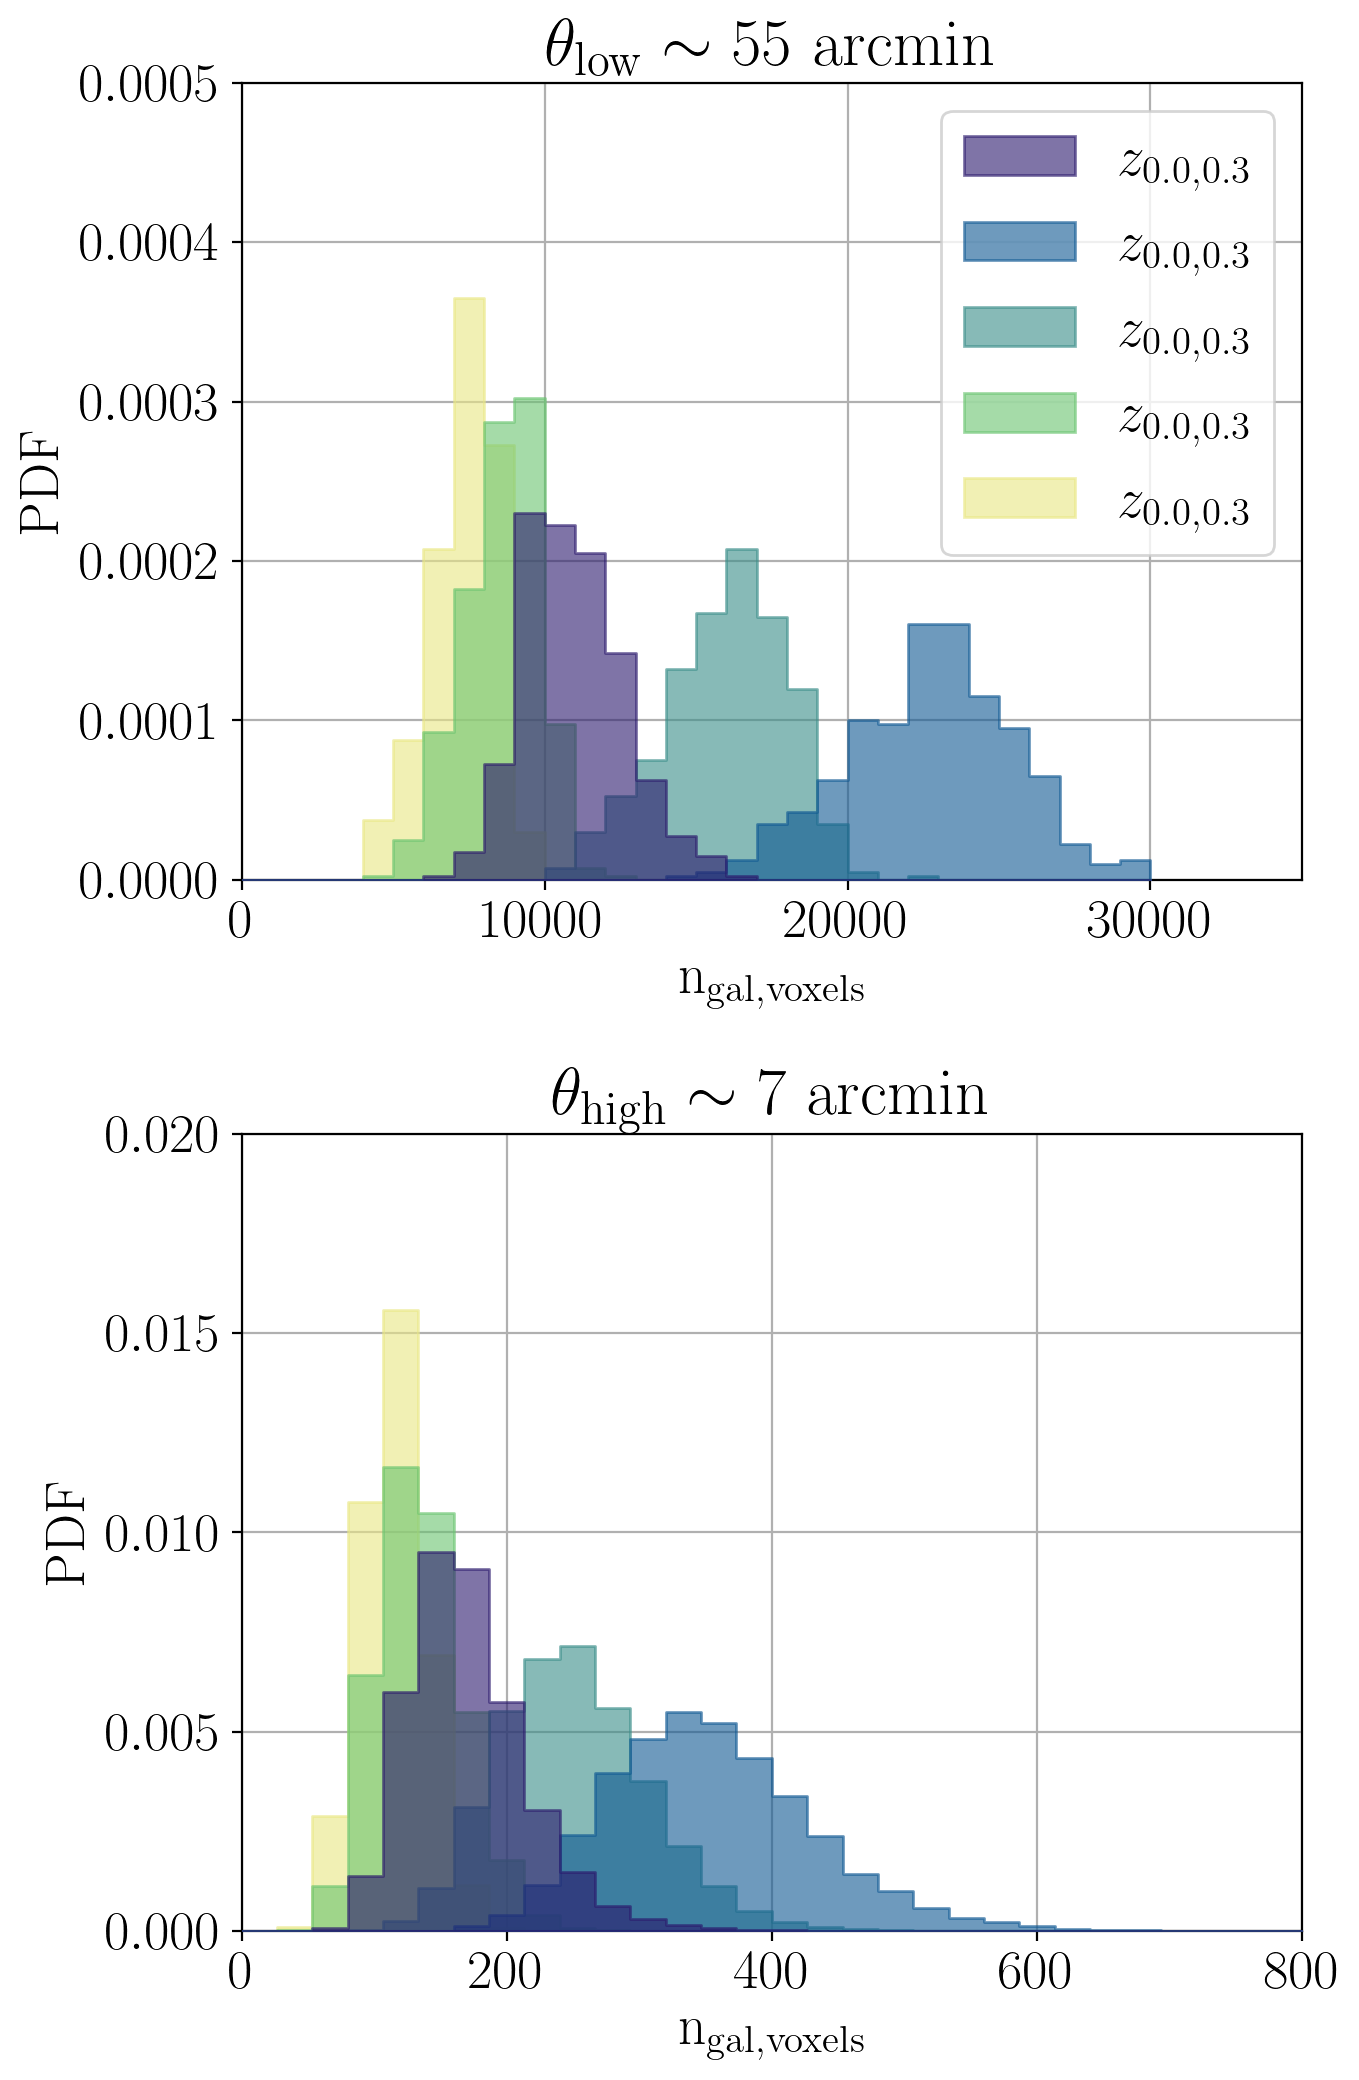

In [10]:
fig=plot.figure(figsize=(new_fig_size[0],new_fig_size[1]*2))

plot.subplot(2,1,1)
L=len(zlist)
for i in range(len(zlist)):
    z=zlist[i]
    sp.hist(pix_Buz_r260_n6[f'n6_{z}_count'],bins=[np.linspace(0,3e4,31)],hist_type='stepfilled',alpha=0.6,
            xlim=[0,3.5e4],ylim=[0,5e-4],color=col_map(1.0*i/(L-0.8)),xlabel='n$_\mathrm{gal,voxels}$',
            label=['$z_{0.0,0.3}$','$z_{0.3,0.6}$','$z_{0.6,0.9}$','$z_{0.9,1.2}$','$z_{1.2,2.5}$'],
            ylabel='PDF',zorder=6-i,title=nlow)

plot.subplot(2,1,2)
L=len(zlist)
for i in range(len(zlist)):
    z=zlist[i]
    sp.hist(pix_Buz_r260_n9[f'n9_{z}_count'],bins=[np.linspace(0,8e2,31)],hist_type='stepfilled',alpha=0.6,
            xlim=[0,8e2],ylim=[0,2e-2],color=col_map(1.0*i/(L-0.8)),xlabel='n$_\mathrm{gal,voxels}$',
            ylabel='PDF',zorder=6-i,title=nhigh)

plot.tight_layout()
plot.savefig('../MWdust_results/count_dist_B260.pdf')
plot.savefig('../MWdust_results/PNG/count_dist_B260.png')
plot.show()

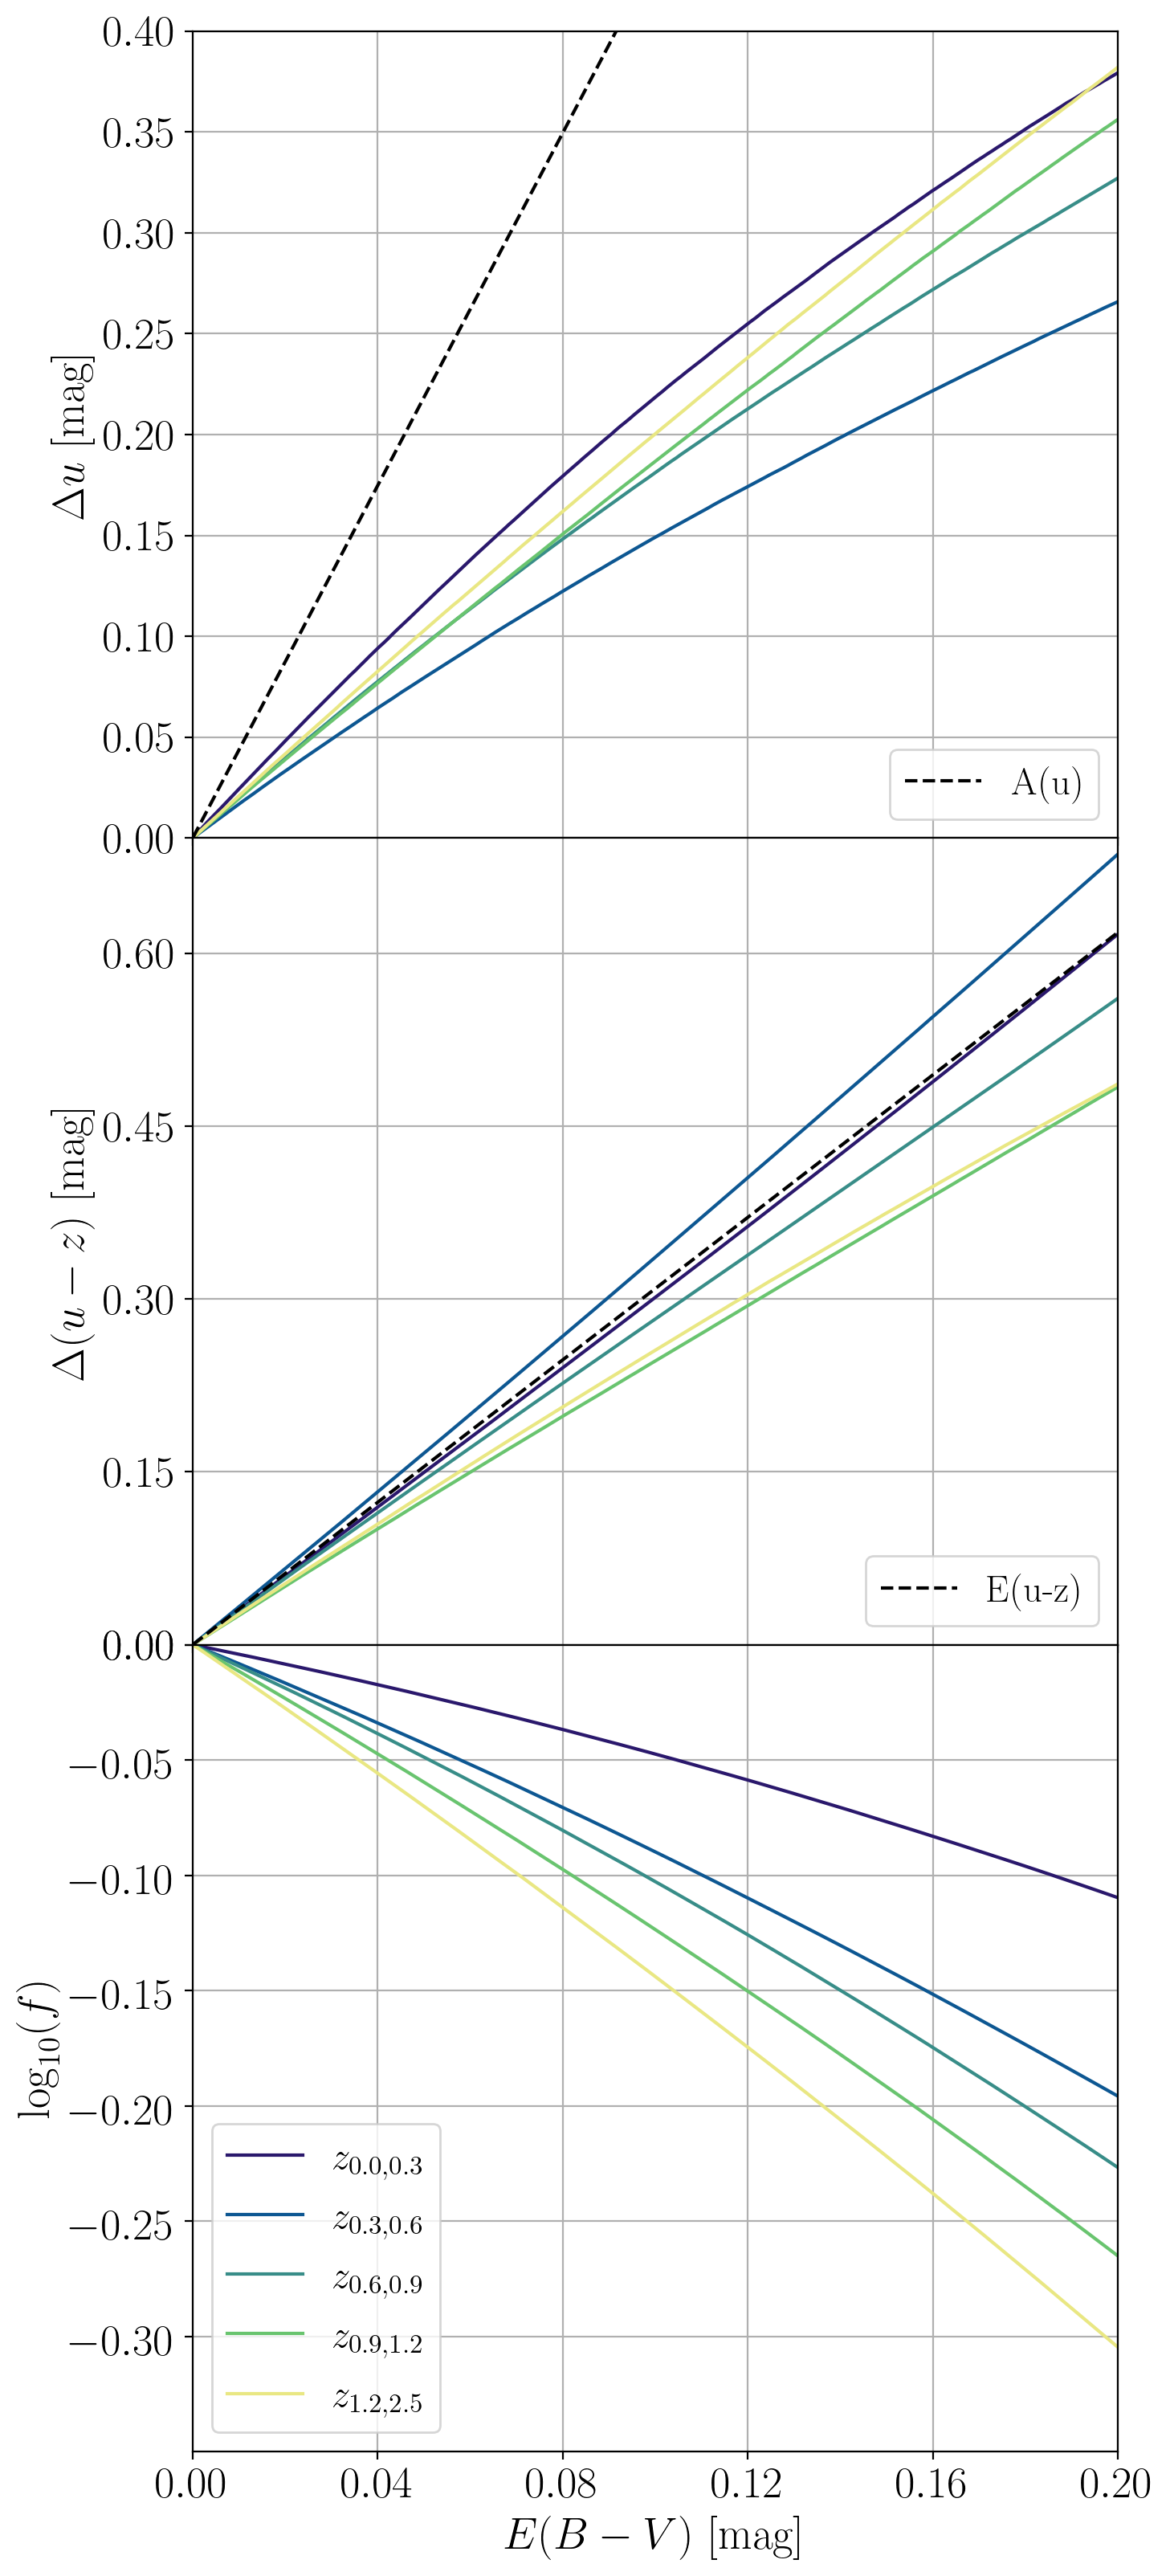

In [11]:
fig=plot.figure(figsize=(new_fig_size[0],new_fig_size[1]*3))
spec=gs.GridSpec(nrows=3,ncols=1,figure=fig,wspace=0,hspace=0,left=0.16,right=0.96,bottom=0.05,top=0.98)
fax=[fig.add_subplot(spec[0,0]),fig.add_subplot(spec[1,0]),fig.add_subplot(spec[2,0])]
temp=fax[0].get_xaxis().set_ticklabels([])
temp=fax[1].get_xaxis().set_ticklabels([])
temp=fax[1].get_yaxis().set_ticks([0.0,0.15,0.3,0.45,0.6])
temp=fax[2].get_yaxis().set_ticks([0.0,-0.05,-0.10,-0.15,-0.20,-0.25,-0.30])
for i in range(3):
    temp=fax[i].get_xaxis().set_ticks([0.0,0.04,0.08,0.12,0.16,0.2])
    fax[i].set_rasterized(True)
   
L=len(zlist)
for i in range(len(zlist)):
    z=zlist[i]
    sp.plot(dust_Buz_r260[z]['EBV'],dust_Buz_r260[z]['mag'],ax=fax[0],ylabel='$\Delta u$ [mag]',
            xlim=[0,0.2],ylim=[0,0.4],color=col_map(1.0*i/(L-0.8)))
    sp.plot(dust_Buz_r260[z]['EBV'],dust_Buz_r260[z]['col'],ax=fax[1],ylabel='$\Delta(u-z)$ [mag]',
            xlim=[0,0.2],ylim=[0,0.7],color=col_map(1.0*i/(L-0.8)))
    sp.plot(dust_Buz_r260[z]['EBV'],dust_Buz_r260[z]['delta'],ax=fax[2],xlabel='$E(B-V)$ [mag]',ylabel='$\log_{10}(f)$',
            xlim=[0,0.2],ylim=[-0.35,0],color=col_map(1.0*i/(L-0.8)))

A,E=extinction_law(1,'u_ap','z_ap')    
sp.axline(a=A,c='k',linestyle='dashed',ax=fax[0])
sp.axline(a=E,c='k',linestyle='dashed',ax=fax[1])

#Legend
fax[0].legend([lines.Line2D([0,1],[0,1],color='k',linestyle='dashed')],['A(u)'],fontsize=17,loc=4)
fax[1].legend([lines.Line2D([0,1],[0,1],color='k',linestyle='dashed')],['E(u-z)'],fontsize=17,loc=4)
fax[2].legend([lines.Line2D([0,1],[0,1],color=col_map(0.0/(L-0.8))),lines.Line2D([0,1],[0,1],color=col_map(1.0/(L-0.8))),
               lines.Line2D([0,1],[0,1],color=col_map(2.0/(L-0.8))),lines.Line2D([0,1],[0,1],color=col_map(3.0/(L-0.8))),
               lines.Line2D([0,1],[0,1],color=col_map(4.0/(L-0.8)))],
              ['$z_{0.0,0.3}$','$z_{0.3,0.6}$','$z_{0.6,0.9}$','$z_{0.9,1.2}$','$z_{1.2,2.5}$'],fontsize=17,loc=3)

plot.savefig('../MWdust_results/lookup_table_B260.pdf')
plot.savefig('../MWdust_results/PNG/lookup_table_B260.png')
plot.show()

# Dust map recovery

In [12]:
map_Buz_r260_n6=map_recovery(6,dust_Buz_r260,pix_Buz_r260_n6)
map_Buz_r260_n9=map_recovery(9,dust_Buz_r260,pix_Buz_r260_n9)

In [20]:
Buz_r260_n6_zorder=[]
Buz_r260_n9_zorder=[]
nlow_val=np.std(map_Buz_r260_n6["output_map"]-map_Buz_r260_n6["input_map"])
nhigh_val=np.std(map_Buz_r260_n9["output_map"]-map_Buz_r260_n9["input_map"])

display(Markdown(f'Buz_r260_STD_final = {nlow_val:.5f} ({nlow}) | {nhigh_val:.5f} ({nhigh})'))

for i in range(len(map_Buz_r260_n6['output_map_combined'])):
    temp_std=np.std(map_Buz_r260_n6["output_map_combined"][i]-map_Buz_r260_n6["input_map"])
    Buz_r260_n6_zorder.append(temp_std)
    nlow_val=f'{temp_std:.5f}'
    temp_std=np.std(map_Buz_r260_n9["output_map_combined"][i]-map_Buz_r260_n9["input_map"])
    Buz_r260_n9_zorder.append(temp_std)
    nhigh_val=f'{temp_std:.5f}'
    display(Markdown(f'Buz_r260_STD_z{i} = {nlow_val} ({nlow}) | {nhigh_val} ({nhigh})'))

Buz_r260_n6_zorder=np.argsort(Buz_r260_n6_zorder)[::-1]
Buz_r260_n9_zorder=np.argsort(Buz_r260_n9_zorder)[::-1]

Buz_r260_STD_final = 0.00465 ($\theta_\mathrm{low}\sim55$ arcmin) | 0.01547 ($\theta_\mathrm{high}\sim7$ arcmin)

Buz_r260_STD_z0 = 0.01482 ($\theta_\mathrm{low}\sim55$ arcmin) | 0.04429 ($\theta_\mathrm{high}\sim7$ arcmin)

Buz_r260_STD_z1 = 0.00765 ($\theta_\mathrm{low}\sim55$ arcmin) | 0.02956 ($\theta_\mathrm{high}\sim7$ arcmin)

Buz_r260_STD_z2 = 0.00713 ($\theta_\mathrm{low}\sim55$ arcmin) | 0.02928 ($\theta_\mathrm{high}\sim7$ arcmin)

Buz_r260_STD_z3 = 0.00609 ($\theta_\mathrm{low}\sim55$ arcmin) | 0.03524 ($\theta_\mathrm{high}\sim7$ arcmin)

Buz_r260_STD_z4 = 0.00767 ($\theta_\mathrm{low}\sim55$ arcmin) | 0.03599 ($\theta_\mathrm{high}\sim7$ arcmin)

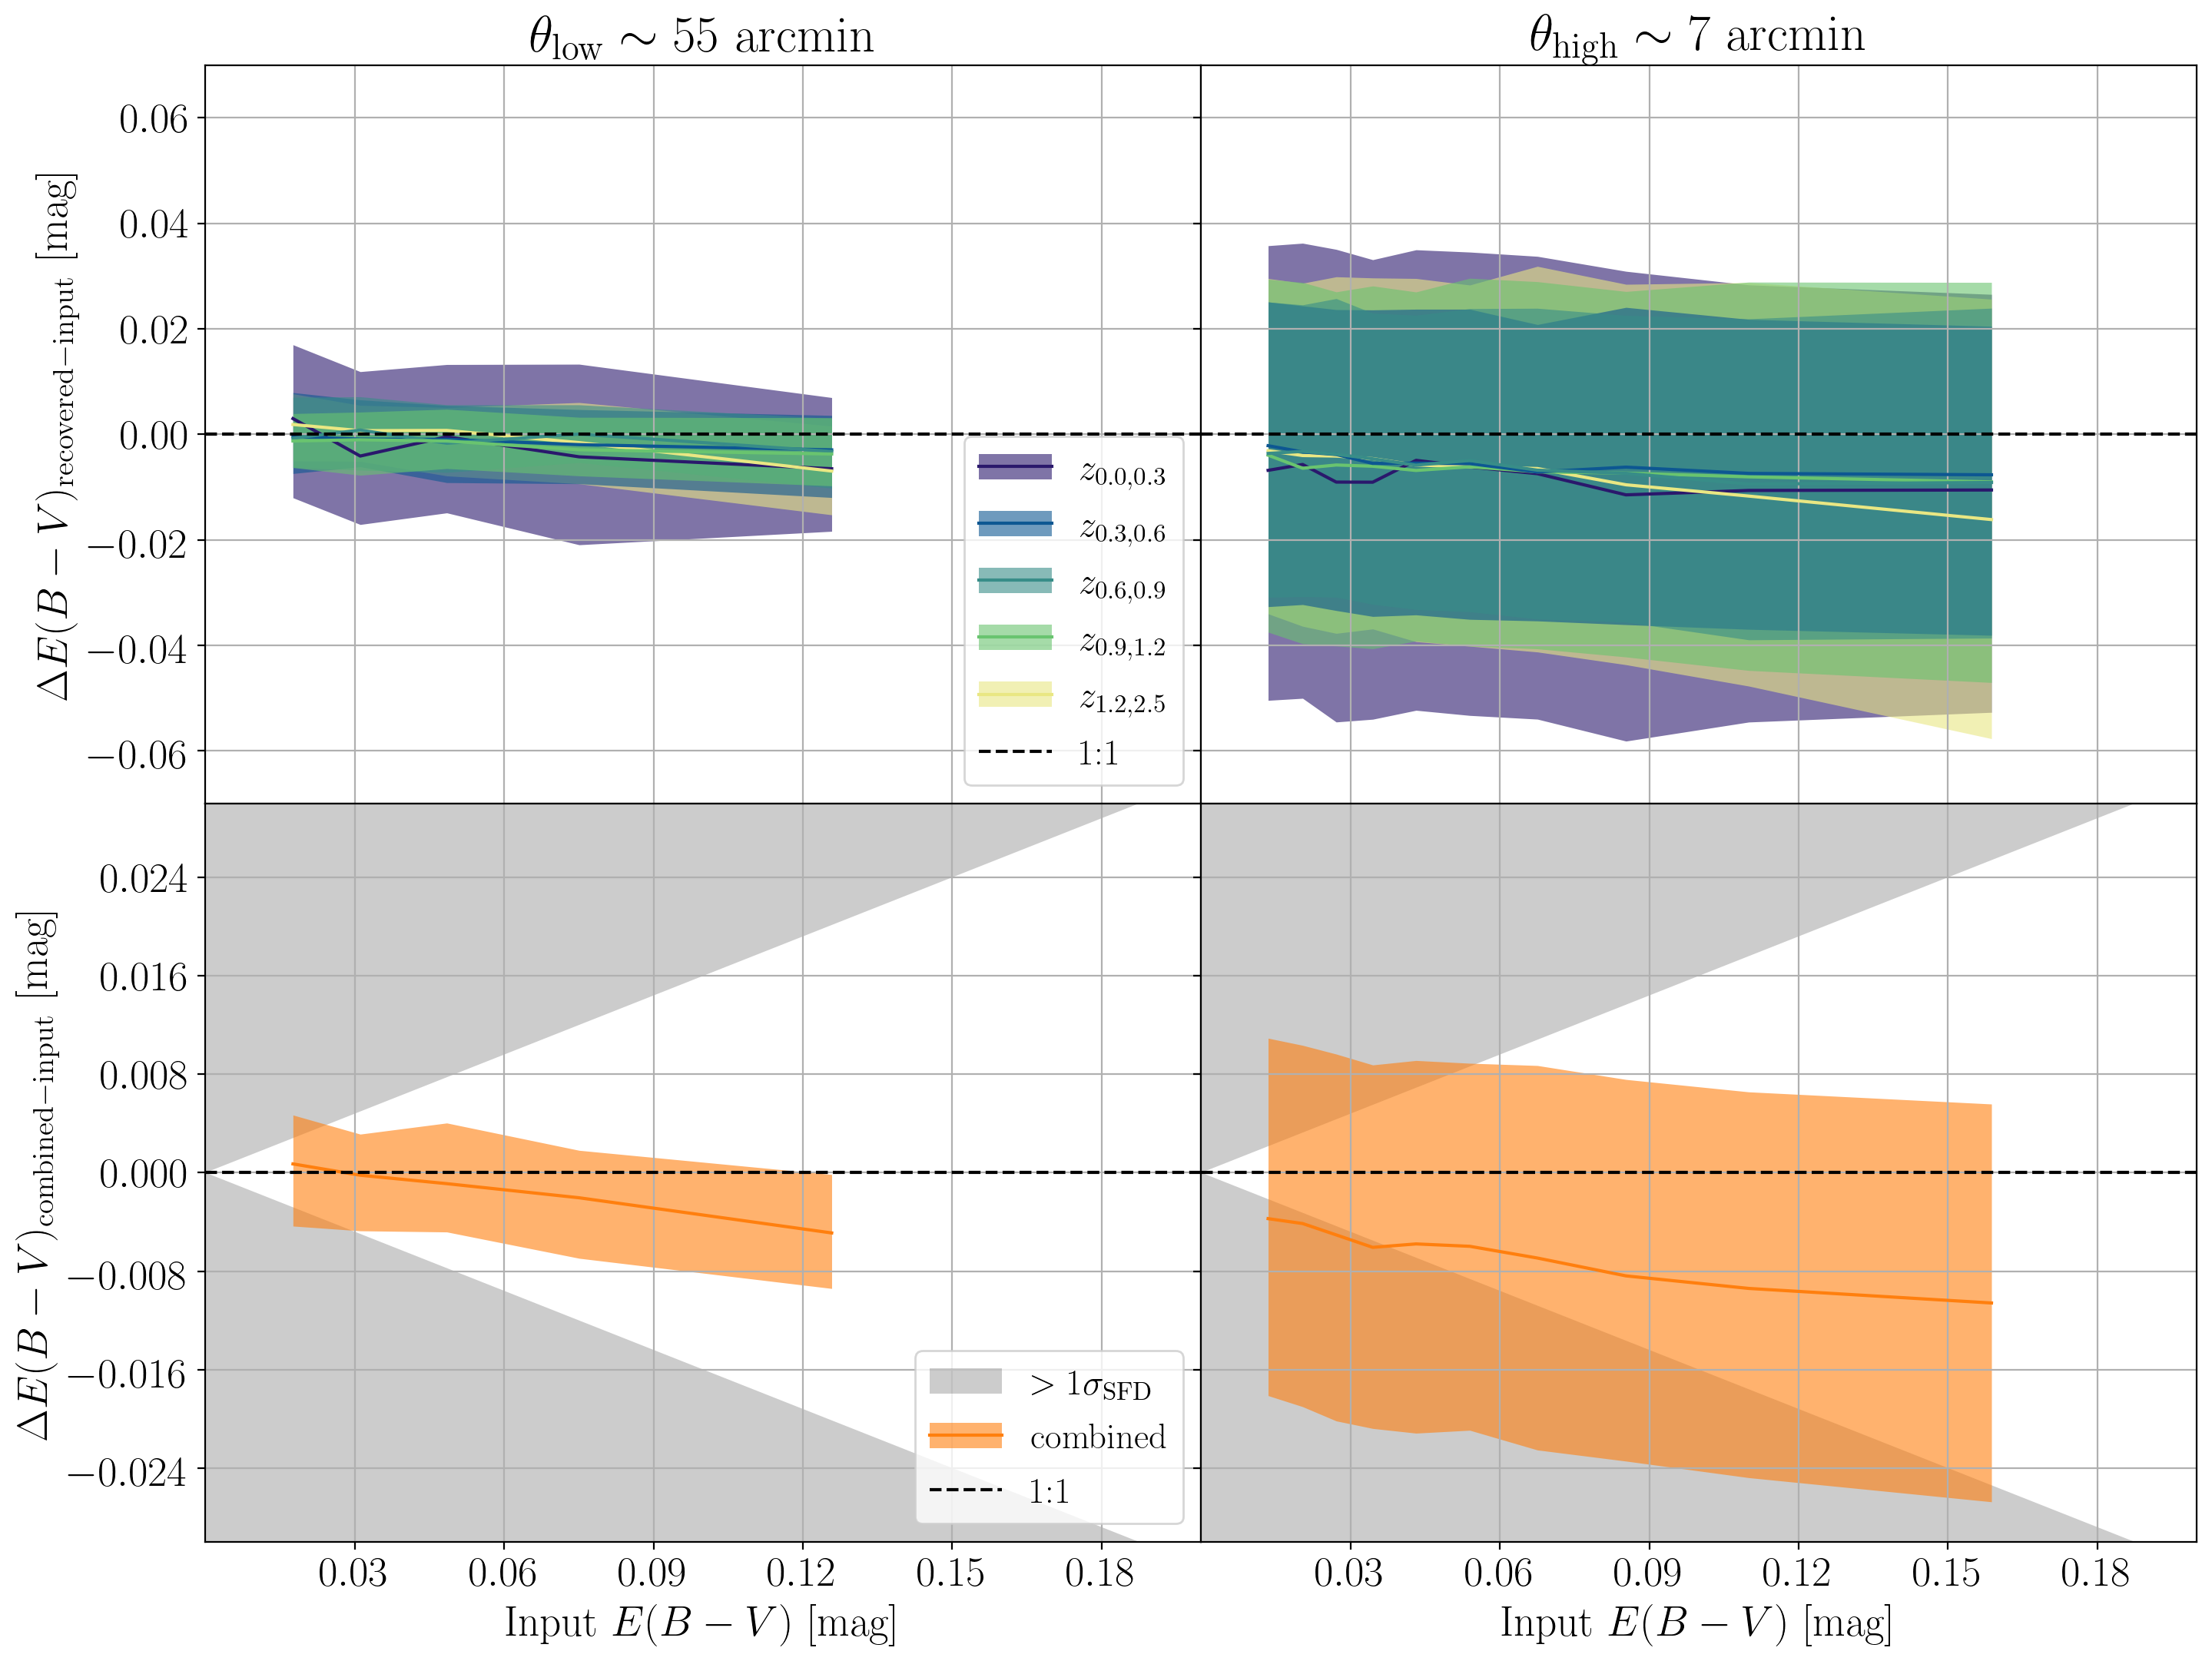

In [21]:
fig=plot.figure(figsize=new_fig_size*2)
spec=gs.GridSpec(nrows=2,ncols=2,figure=fig,wspace=0,hspace=0,left=0.09,right=0.99,bottom=0.07,top=0.96)
fax=[[fig.add_subplot(spec[0,0]),fig.add_subplot(spec[0,1])],[fig.add_subplot(spec[1,0]),fig.add_subplot(spec[1,1])]]
temp=fax[0][0].get_xaxis().set_ticklabels([])
temp=fax[0][1].get_xaxis().set_ticklabels([])
temp=fax[0][1].get_yaxis().set_ticklabels([])
temp=fax[1][1].get_yaxis().set_ticklabels([])
for i in range(2):
    for j in range(2):
        temp=fax[0][j].get_yaxis().set_ticks([-0.06,-0.040,-0.02,0,0.02,0.04,0.06])
        temp=fax[1][j].get_yaxis().set_ticks([-0.024,-0.016,-0.008,0,0.008,0.016,0.024])
        temp=fax[i][j].get_xaxis().set_ticks([0.03,0.06,0.09,0.12,0.15,0.18])
        fax[i][j].set_rasterized(True)

#nlow
fax[0][0].set_title(nlow)
L=len(map_Buz_r260_n6['output_map_combined'])
for i in Buz_r260_n6_zorder:
    sp.errorband(map_Buz_r260_n6['input_map'],map_Buz_r260_n6['output_map_combined'][i]-map_Buz_r260_n6['input_map'],
                 stat_mid='median',bin_type='equal',ylabel='$\Delta E(B-V)_{\mathrm{recovered}-\mathrm{input}}$ [mag]',
                 stat_low=16,stat_high=84,line=True,ax=fax[0][0],xlim=[0,0.2],ylim=[-0.07,0.07],bins=5,
                 band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6},
                 line_kw={'c':col_map(1.0*i/(L-0.8))})
sp.axline(a=0,c='k',linestyle='dashed',ax=fax[0][0])
fax[1][0].fill_between(np.linspace(0,2,100),0.2,0.16*np.linspace(0,2,100),color='k',alpha=0.2,linewidth=0)
fax[1][0].fill_between(np.linspace(0,2,100),-0.2,-0.16*np.linspace(0,2,100),color='k',alpha=0.2,linewidth=0)
sp.errorband(map_Buz_r260_n6['input_map'],map_Buz_r260_n6['output_map']-map_Buz_r260_n6['input_map'],stat_mid='median',
             bin_type='equal',bins=5,ylabel='$\Delta E(B-V)_{\mathrm{combined}-\mathrm{input}}$ [mag]',stat_low=16,
             stat_high=84,line=True,ax=fax[1][0],xlim=[0,0.2],ylim=[-0.03,0.03],xlabel='Input $E(B-V)$ [mag]',
             band_kw={'color':'C1','alpha':0.6},line_kw={'c':'C1'})
sp.axline(a=0,c='k',linestyle='dashed',ax=fax[1][0])

#nhigh
fax[0][1].set_title(nhigh)
for i in Buz_r260_n9_zorder:
    sp.errorband(map_Buz_r260_n9['input_map'],map_Buz_r260_n9['output_map_combined'][i]-map_Buz_r260_n9['input_map'],stat_mid='median',bin_type='equal',
                 bins=10,stat_low=16,stat_high=84,line=True,ax=fax[0][1],xlim=[0,0.2],ylim=[-0.07,0.07],
                 band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6},line_kw={'c':col_map(1.0*i/(L-0.8))})
sp.axline(a=0,c='k',linestyle='dashed',ax=fax[0][1])
fax[1][1].fill_between(np.linspace(0,2,100),0.2,0.16*np.linspace(0,2,100),color='k',alpha=0.2,linewidth=0)
fax[1][1].fill_between(np.linspace(0,2,100),-0.2,-0.16*np.linspace(0,2,100),color='k',alpha=0.2,linewidth=0)
sp.errorband(map_Buz_r260_n9['input_map'],map_Buz_r260_n9['output_map']-map_Buz_r260_n9['input_map'],stat_mid='median',bin_type='equal',xlabel='Input $E(B-V)$ [mag]',
                 stat_low=16,stat_high=84,line=True,ax=fax[1][1],xlim=[0,0.2],ylim=[-0.03,0.03],
                 bins=10,band_kw={'color':'C1','alpha':0.6},line_kw={'c':'C1'})
sp.axline(a=0,c='k',linestyle='dashed',ax=fax[1][1])

#Legend
fax[0][0].legend([(patches.Patch(color=col_map(0.0/(L-0.8)),alpha=0.6,linewidth=0),
                   lines.Line2D([0,1],[0,1],color=col_map(0.0/(L-0.8)))),
                  (patches.Patch(color=col_map(1.0/(L-0.8)),alpha=0.6,linewidth=0),
                   lines.Line2D([0,1],[0,1],color=col_map(1.0/(L-0.8)))),
                  (patches.Patch(color=col_map(2.0/(L-0.8)),alpha=0.6,linewidth=0),
                   lines.Line2D([0,1],[0,1],color=col_map(2.0/(L-0.8)))),
                  (patches.Patch(color=col_map(3.0/(L-0.8)),alpha=0.6,linewidth=0),
                   lines.Line2D([0,1],[0,1],color=col_map(3.0/(L-0.8)))),
                  (patches.Patch(color=col_map(4.0/(L-0.8)),alpha=0.6,linewidth=0),
                   lines.Line2D([0,1],[0,1],color=col_map(4.0/(L-0.8)))),
                  lines.Line2D([0,1],[0,1],color='k',linestyle='dashed')],
                 ['$z_{0.0,0.3}$','$z_{0.3,0.6}$','$z_{0.6,0.9}$','$z_{0.9,1.2}$','$z_{1.2,2.5}$','1:1'],
                 fontsize=17,handler_map={tuple:HandlerTuple(ndivide=1)},loc=4)
fax[1][0].legend([patches.Patch(color='k',alpha=0.2,linewidth=0),
                  (patches.Patch(color='C1',alpha=0.6,linewidth=0),lines.Line2D([0,1],[0,1],color='C1')),
                  lines.Line2D([0,1],[0,1],color='k',linestyle='dashed')],
                 ['$>1\sigma_\mathrm{SFD}$','combined','1:1'],
                 fontsize=17,handler_map={tuple:HandlerTuple(ndivide=1)},loc=4)

plot.savefig('../MWdust_results/EBV_recovery_B260.pdf')
plot.savefig('../MWdust_results/PNG/EBV_recovery_B260.png')
plot.show()

In [22]:
SFD_Buz_r260_n6=np.array([np.nan for i in range(hp.pixelfunc.nside2npix(2**6))])
rec_Buz_r260_n6=np.array([np.nan for i in range(hp.pixelfunc.nside2npix(2**6))])
for i in range(len(map_Buz_r260_n6['pix'])):
    SFD_Buz_r260_n6[map_Buz_r260_n6['pix'][i]]=map_Buz_r260_n6['input_map'][i]
    rec_Buz_r260_n6[map_Buz_r260_n6['pix'][i]]=map_Buz_r260_n6['output_map'][i]

rec_Buz_r260_n6_z=[np.array([np.nan for i in range(hp.pixelfunc.nside2npix(2**6))]) for z in zlist]
for i in range(len(zlist)):
    for j in range(len(map_Buz_r260_n6['pix'])):
        rec_Buz_r260_n6_z[i][map_Buz_r260_n6['pix'][j]]=map_Buz_r260_n6["output_map_combined"][i][j]

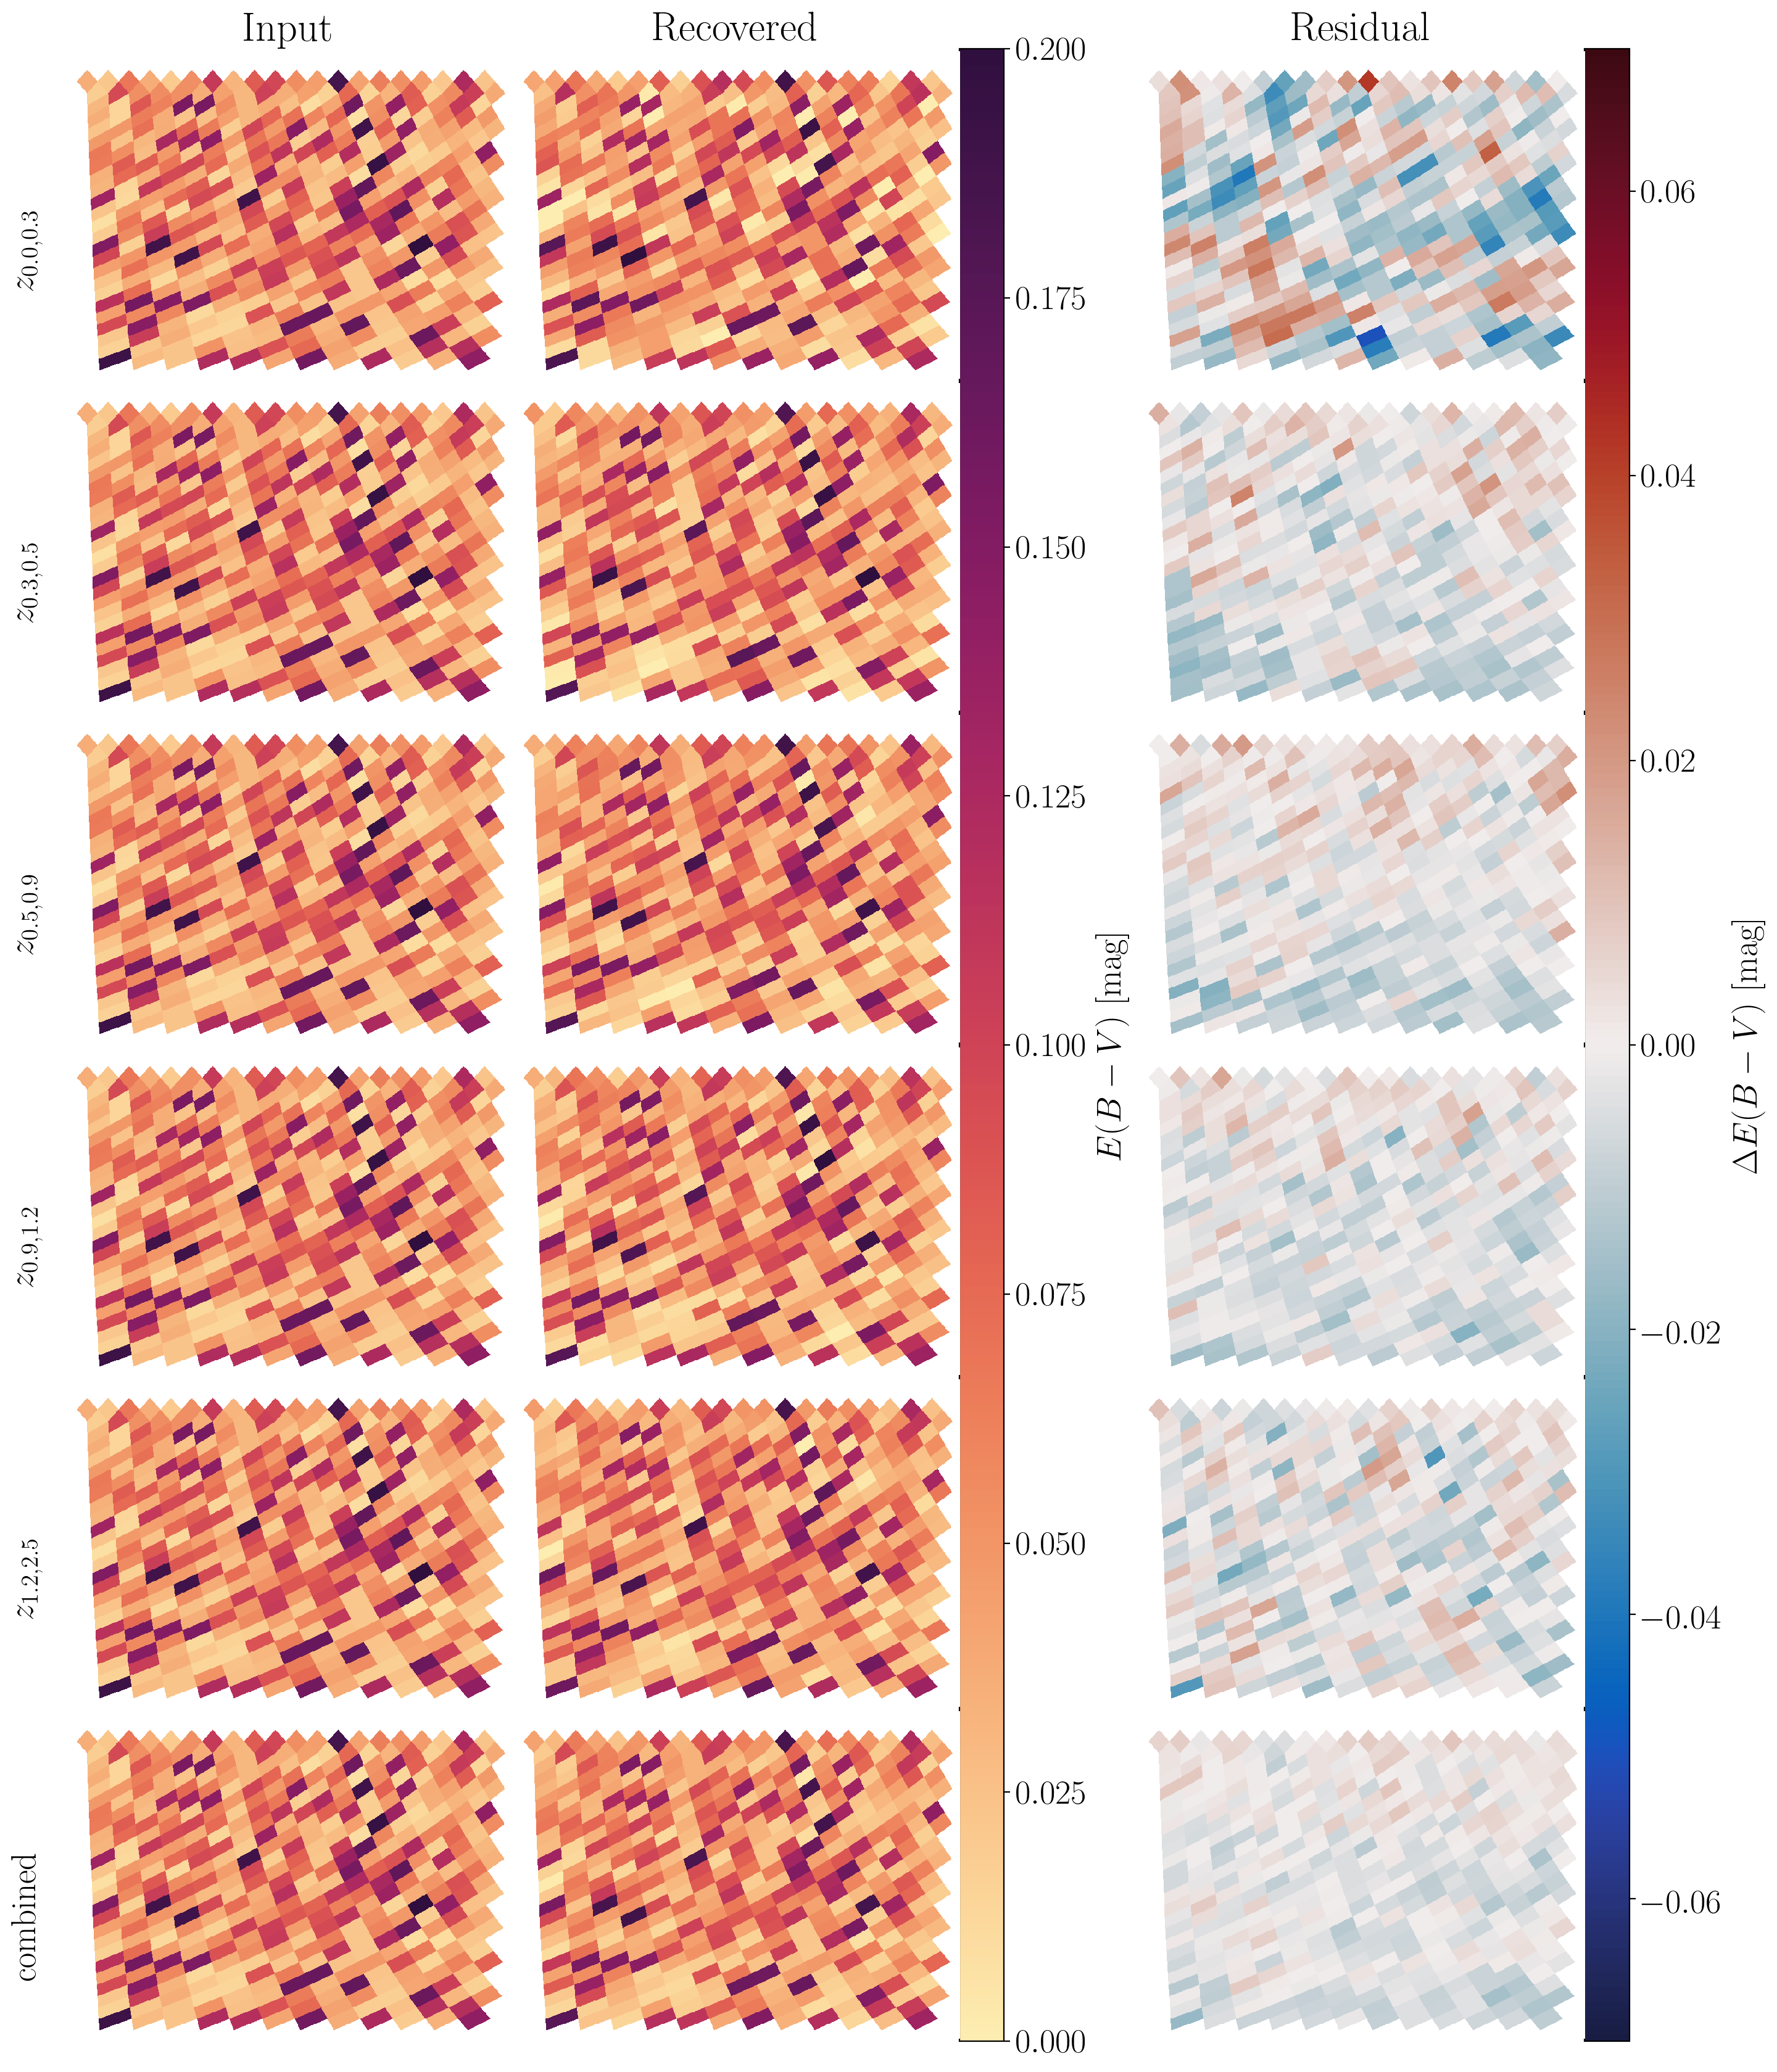

In [57]:
fig=plot.figure(100,figsize=(14.4,17))
spec=gs.GridSpec(nrows=6,ncols=36,figure=fig,wspace=0,hspace=0,left=0.015,right=0.92,bottom=0.02,top=0.97)
fax=[[fig.add_subplot(spec[0,1:11]),fig.add_subplot(spec[0,11:21]),fig.add_subplot(spec[0,25:35])],
     [fig.add_subplot(spec[1,1:11]),fig.add_subplot(spec[1,11:21]),fig.add_subplot(spec[1,25:35])],
     [fig.add_subplot(spec[2,1:11]),fig.add_subplot(spec[2,11:21]),fig.add_subplot(spec[2,25:35])],
     [fig.add_subplot(spec[3,1:11]),fig.add_subplot(spec[3,11:21]),fig.add_subplot(spec[3,25:35])],
     [fig.add_subplot(spec[4,1:11]),fig.add_subplot(spec[4,11:21]),fig.add_subplot(spec[4,25:35])],
     [fig.add_subplot(spec[5,1:11]),fig.add_subplot(spec[5,11:21]),fig.add_subplot(spec[5,25:35])]]
cbar_1=fig.add_subplot(spec[:,21])
cbar_2=fig.add_subplot(spec[:,35])
ylabels=[fig.add_subplot(spec[0,0],frame_on=False),fig.add_subplot(spec[1,0],frame_on=False),fig.add_subplot(spec[2,0],frame_on=False),
         fig.add_subplot(spec[3,0],frame_on=False),fig.add_subplot(spec[4,0],frame_on=False),fig.add_subplot(spec[5,0],frame_on=False)]
for i in range(6):
    for j in range(3):
        temp=fax[i][j].get_xaxis().set_ticklabels([])
        temp=fax[i][j].get_yaxis().set_ticklabels([])
for y in ylabels:
    temp=y.get_xaxis().set_ticks([])
    temp=y.get_yaxis().set_ticks([])

# z015
plot.sca(fax[0][0])
hp.cartview(SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],cbar=False,min=0,max=0.2,cmap=cmo.cm.matter,
            title='Input',badcolor='white',hold=True)
plot.sca(fax[0][1])
hp.cartview(rec_Buz_r260_n6_z[0],fig=100,lonra=[60,90],latra=[-61,-39],cbar=False,min=0,max=0.2,cmap=cmo.cm.matter,
            title='Recovered',badcolor='white',hold=True)
plot.sca(fax[0][2])
hp.cartview(rec_Buz_r260_n6_z[0]-SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],cbar=False,min=-0.07,max=0.07,
            cmap=cmo.cm.balance,title='Residual',badcolor='white',hold=True)

# z045
plot.sca(fax[1][0])
hp.cartview(SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,min=0,max=0.2,
            cmap=cmo.cm.matter,badcolor='white',hold=True)
plot.sca(fax[1][1])
hp.cartview(rec_Buz_r260_n6_z[1],fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,min=0,max=0.2,
            cmap=cmo.cm.matter,badcolor='white',hold=True)
plot.sca(fax[1][2])
hp.cartview(rec_Buz_r260_n6_z[1]-SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,
            min=-0.07,max=0.07,cmap=cmo.cm.balance,badcolor='white',hold=True)

# z075
plot.sca(fax[2][0])
hp.cartview(SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,min=0,max=0.2,
            cmap=cmo.cm.matter,badcolor='white',hold=True)
plot.sca(fax[2][1])
hp.cartview(rec_Buz_r260_n6_z[2],fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,min=0,max=0.2,
            cmap=cmo.cm.matter,badcolor='white',hold=True)
plot.sca(fax[2][2])
hp.cartview(rec_Buz_r260_n6_z[2]-SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,
            min=-0.07,max=0.07,cmap=cmo.cm.balance,badcolor='white',hold=True)

# z105
plot.sca(fax[3][0])
hp.cartview(SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,min=0,max=0.2,
            cmap=cmo.cm.matter,badcolor='white',hold=True)
plot.sca(fax[3][1])
hp.cartview(rec_Buz_r260_n6_z[3],fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,min=0,max=0.2,
            cmap=cmo.cm.matter,badcolor='white',hold=True)
plot.sca(fax[3][2])
hp.cartview(rec_Buz_r260_n6_z[3]-SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,
            min=-0.07,max=0.07,cmap=cmo.cm.balance,badcolor='white',hold=True)

# z185
plot.sca(fax[4][0])
hp.cartview(SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,min=0,max=0.2,
            cmap=cmo.cm.matter,badcolor='white',hold=True)
plot.sca(fax[4][1])
hp.cartview(rec_Buz_r260_n6_z[4],fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,min=0,max=0.2,
            cmap=cmo.cm.matter,badcolor='white',hold=True)
plot.sca(fax[4][2])
hp.cartview(rec_Buz_r260_n6_z[4]-SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,
            min=-0.07,max=0.07,cmap=cmo.cm.balance,badcolor='white',hold=True)

#final
plot.sca(fax[5][0])
hp.cartview(SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,min=0,max=0.2,
            cmap=cmo.cm.matter,badcolor='white',hold=True)
plot.sca(fax[5][1])
hp.cartview(rec_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,min=0,max=0.2,
            cmap=cmo.cm.matter,badcolor='white',hold=True)
plot.sca(fax[5][2])
hp.cartview(rec_Buz_r260_n6-SFD_Buz_r260_n6,fig=100,lonra=[60,90],latra=[-61,-39],title=None,cbar=False,
            min=-0.07,max=0.07,cmap=cmo.cm.balance,badcolor='white',hold=True)

ylabels[0].text(-0.2,0.3,'$z_{0.0,0.3}$',rotation=90)
ylabels[1].text(-0.2,0.3,'$z_{0.3,0.5}$',rotation=90)
ylabels[2].text(-0.2,0.3,'$z_{0.5,0.9}$',rotation=90)
ylabels[3].text(-0.2,0.3,'$z_{0.9,1.2}$',rotation=90)
ylabels[4].text(-0.2,0.3,'$z_{1.2,2.5}$',rotation=90)
ylabels[5].text(-0.2,0.2,'combined',rotation=90)
cbar1=plot.colorbar(cax=cbar_1,mappable=cm.ScalarMappable(norm=col.Normalize(vmin=0,vmax=0.2),cmap=cmo.cm.matter))
cbar1.set_label('$E(B-V)$ [mag]')
cbar2=plot.colorbar(cax=cbar_2,mappable=cm.ScalarMappable(norm=col.Normalize(vmin=-0.07,vmax=0.07),cmap=cmo.cm.balance))
cbar2.set_label('$\Delta E(B-V)$ [mag]')

plot.savefig('../MWdust_results/EBV_map_B260_n6.pdf')
plot.savefig('../MWdust_results/PNG/EBV_map_B260_n6.png')
plot.show()

# $\delta$ recovery

In [25]:
delta_Buz_r260_n6=delta_recovery(6,int_Buz_r260_n6,pix_Buz_r260_n6,dust_Buz_r260,map_Buz_r260_n6)
delta_Buz_r260_n9=delta_recovery(9,int_Buz_r260_n9,pix_Buz_r260_n9,dust_Buz_r260,map_Buz_r260_n9)

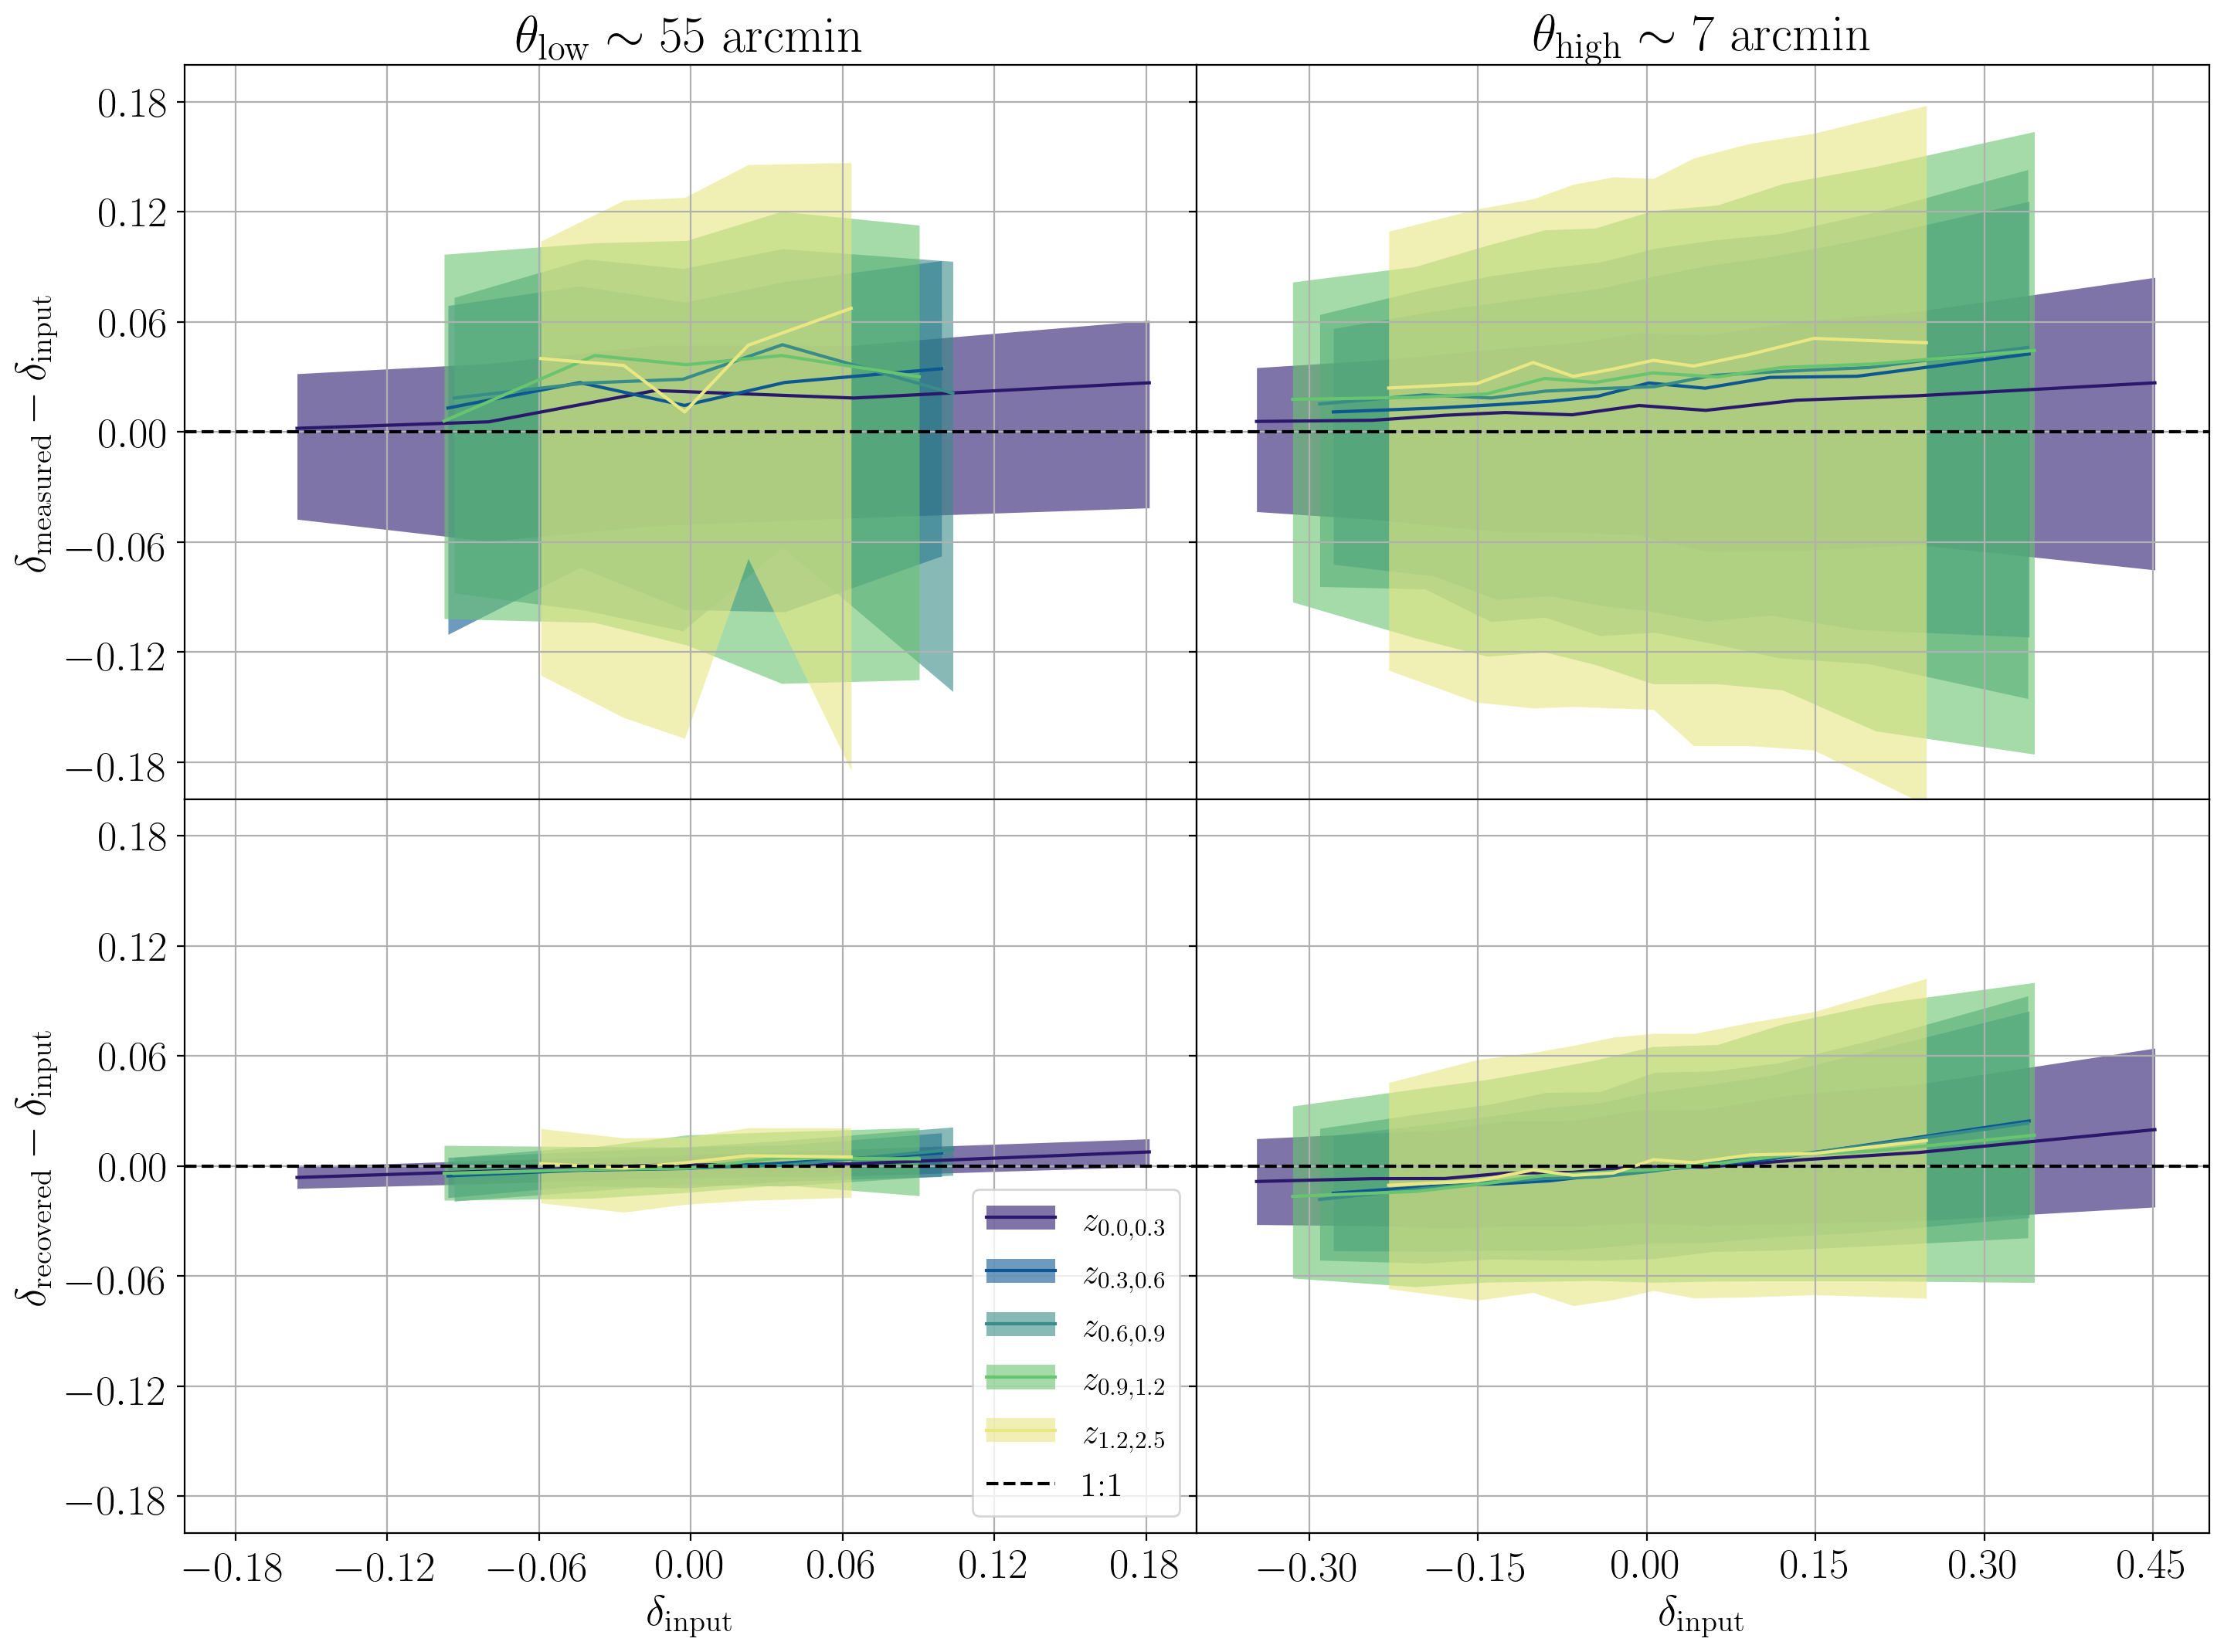

In [40]:
col_map=cm.get_cmap(cmo.cm.haline)
delta_Buz_r260={}

fig=plot.figure(figsize=new_fig_size*2)
spec=gs.GridSpec(nrows=2,ncols=2,figure=fig,wspace=0,hspace=0,left=0.08,right=0.99,bottom=0.07,top=0.95)
fax=[[fig.add_subplot(spec[0,0]),fig.add_subplot(spec[0,1])],
     [fig.add_subplot(spec[1,0]),fig.add_subplot(spec[1,1])]]
temp=fax[0][1].get_yaxis().set_ticklabels([])
temp=fax[1][1].get_yaxis().set_ticklabels([])
temp=fax[0][0].get_xaxis().set_ticklabels([])
temp=fax[0][1].get_xaxis().set_ticklabels([])
for i in range(2):
    for j in range(2):
        temp=fax[i][0].get_xaxis().set_ticks([-0.18,-0.12,-0.06,0.0,0.06,0.12,0.18])
        temp=fax[i][1].get_xaxis().set_ticks([-0.3,-0.15,0.0,0.15,0.30,0.45])
        temp=fax[i][j].get_yaxis().set_ticks([-0.18,-0.12,-0.06,0.0,0.06,0.12,0.18])
        fax[i][j].set_rasterized(True)
zlist=['z015','z045','z075','z105','z185']

# nlow
fax[0][0].set_title(nlow)
for i in range(len(zlist)):
    z=zlist[i]
    sp.errorband(delta_Buz_r260_n6[f'delta_input_{z}'],delta_Buz_r260_n6[f'delta_measured_{z}']-delta_Buz_r260_n6[f'delta_input_{z}'],
                 stat_mid='median',bin_type='equal',stat_low=16,stat_high=84,line=True,ax=fax[0][0],xlim=[-0.2,0.2],ylim=[-0.2,0.2],
                 bins=5,line_kw={'c':col_map(1.0*i/(L-0.8))},band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6},
                 ylabel='$\delta_\mathrm{measured}-\delta_\mathrm{input}$')
    sp.errorband(delta_Buz_r260_n6[f'delta_input_{z}'],delta_Buz_r260_n6[f'delta_recovered_{z}']-delta_Buz_r260_n6[f'delta_input_{z}'],
                 stat_mid='median',bin_type='equal',stat_low=16,ylabel='$\delta_\mathrm{recovered}-\delta_\mathrm{input}$',
                 stat_high=84,line=True,ax=fax[1][0],bins=5,band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6},
                 xlabel='$\delta_\mathrm{input}$',xlim=[-0.2,0.2],ylim=[-0.2,0.2],line_kw={'c':col_map(1.0*i/(L-0.8))})
sp.axline(a=0,c='k',linestyle='dashed',ax=fax[0][0])
sp.axline(a=0,c='k',linestyle='dashed',ax=fax[1][0])

# nhigh
fax[0][1].set_title(nhigh)
for i in range(len(zlist)):
    z=zlist[i]
    sp.errorband(delta_Buz_r260_n9[f'delta_input_{z}'],delta_Buz_r260_n9[f'delta_measured_{z}']-delta_Buz_r260_n9[f'delta_input_{z}'],
                 stat_mid='median',bin_type='equal',stat_low=16,stat_high=84,line=True,ax=fax[0][1],xlim=[-0.4,0.5],ylim=[-0.2,0.2],
                 bins=10,line_kw={'c':col_map(1.0*i/(L-0.8))},band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6})
    sp.errorband(delta_Buz_r260_n9[f'delta_input_{z}'],delta_Buz_r260_n9[f'delta_recovered_{z}']-delta_Buz_r260_n9[f'delta_input_{z}'],
                 stat_mid='median',bin_type='equal',stat_low=16,stat_high=84,line=True,ax=fax[1][1],bins=10,xlim=[-0.4,0.5],
                 band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6},xlabel='$\delta_\mathrm{input}$',ylim=[-0.2,0.2],
                 line_kw={'c':col_map(1.0*i/(L-0.8))})
sp.axline(a=0,c='k',linestyle='dashed',ax=fax[0][1])
sp.axline(a=0,c='k',linestyle='dashed',ax=fax[1][1])

#Legend
fax[1][0].legend([(patches.Patch(color=col_map(0.0/(L-0.8)),alpha=0.6,linewidth=0),
                   lines.Line2D([0,1],[0,1],color=col_map(0.0/(L-0.8)))),
                  (patches.Patch(color=col_map(1.0/(L-0.8)),alpha=0.6,linewidth=0),
                   lines.Line2D([0,1],[0,1],color=col_map(1.0/(L-0.8)))),
                  (patches.Patch(color=col_map(2.0/(L-0.8)),alpha=0.6,linewidth=0),
                   lines.Line2D([0,1],[0,1],color=col_map(2.0/(L-0.8)))),
                  (patches.Patch(color=col_map(3.0/(L-0.8)),alpha=0.6,linewidth=0),
                   lines.Line2D([0,1],[0,1],color=col_map(3.0/(L-0.8)))),
                  (patches.Patch(color=col_map(4.0/(L-0.8)),alpha=0.6,linewidth=0),
                   lines.Line2D([0,1],[0,1],color=col_map(4.0/(L-0.8)))),
                  lines.Line2D([0,1],[0,1],color='k',linestyle='dashed')],
                 ['$z_{0.0,0.3}$','$z_{0.3,0.6}$','$z_{0.6,0.9}$','$z_{0.9,1.2}$','$z_{1.2,2.5}$','1:1'],
                 fontsize=16,handler_map={tuple:HandlerTuple(ndivide=1)},loc=4)

plot.savefig('../MWdust_results/delta_recovery_B260.pdf')
plot.savefig('../MWdust_results/PNG/delta_recovery_B260.png')
plot.show()

In [43]:
for z in zlist:
    display(Markdown(f'Buz_r260_STD_final = {np.std(delta_Buz_r260_n6[f"delta_input_{z}"]-delta_Buz_r260_n6[f"delta_recovered_{z}"]):.5f}'))

Buz_r260_STD_final = 0.00870

Buz_r260_STD_final = 0.01134

Buz_r260_STD_final = 0.01284

Buz_r260_STD_final = 0.01549

Buz_r260_STD_final = 0.01971

In [44]:
delta_input_Buz_r260_n6,delta_measured_Buz_r260_n6,delta_recovered_Buz_r260_n6={},{},{}
zlist=['z015','z045','z075','z105','z185']
for z in zlist:
    di=np.array([np.nan for i in range(hp.pixelfunc.nside2npix(2**6))])
    dm=np.array([np.nan for i in range(hp.pixelfunc.nside2npix(2**6))])
    dr=np.array([np.nan for i in range(hp.pixelfunc.nside2npix(2**6))])
    for i in range(len(map_Buz_r260_n6['pix'])):
        di[map_Buz_r260_n6['pix'][i]]=delta_Buz_r260_n6[f'delta_input_{z}'][i]
        dm[map_Buz_r260_n6['pix'][i]]=delta_Buz_r260_n6[f'delta_measured_{z}'][i]
        dr[map_Buz_r260_n6['pix'][i]]=delta_Buz_r260_n6[f'delta_recovered_{z}'][i]
    delta_input_Buz_r260_n6[z]=di
    delta_measured_Buz_r260_n6[z]=dm
    delta_recovered_Buz_r260_n6[z]=dr

spl_delta=interp.UnivariateSpline(dust_Buz_r260['z185']['deltaEBV']-np.min(dust_Buz_r260['z185']['deltaEBV']),dust_Buz_r260['z185']['delta']-np.max(dust_Buz_r260['z185']['delta']),ext=0)
induced_delta=10**spl_delta(SFD_Buz_r260_n6)
induced_delta-=np.nanmean(induced_delta)
induced_delta[SFD_Buz_r260_n6==np.nan]=np.nan

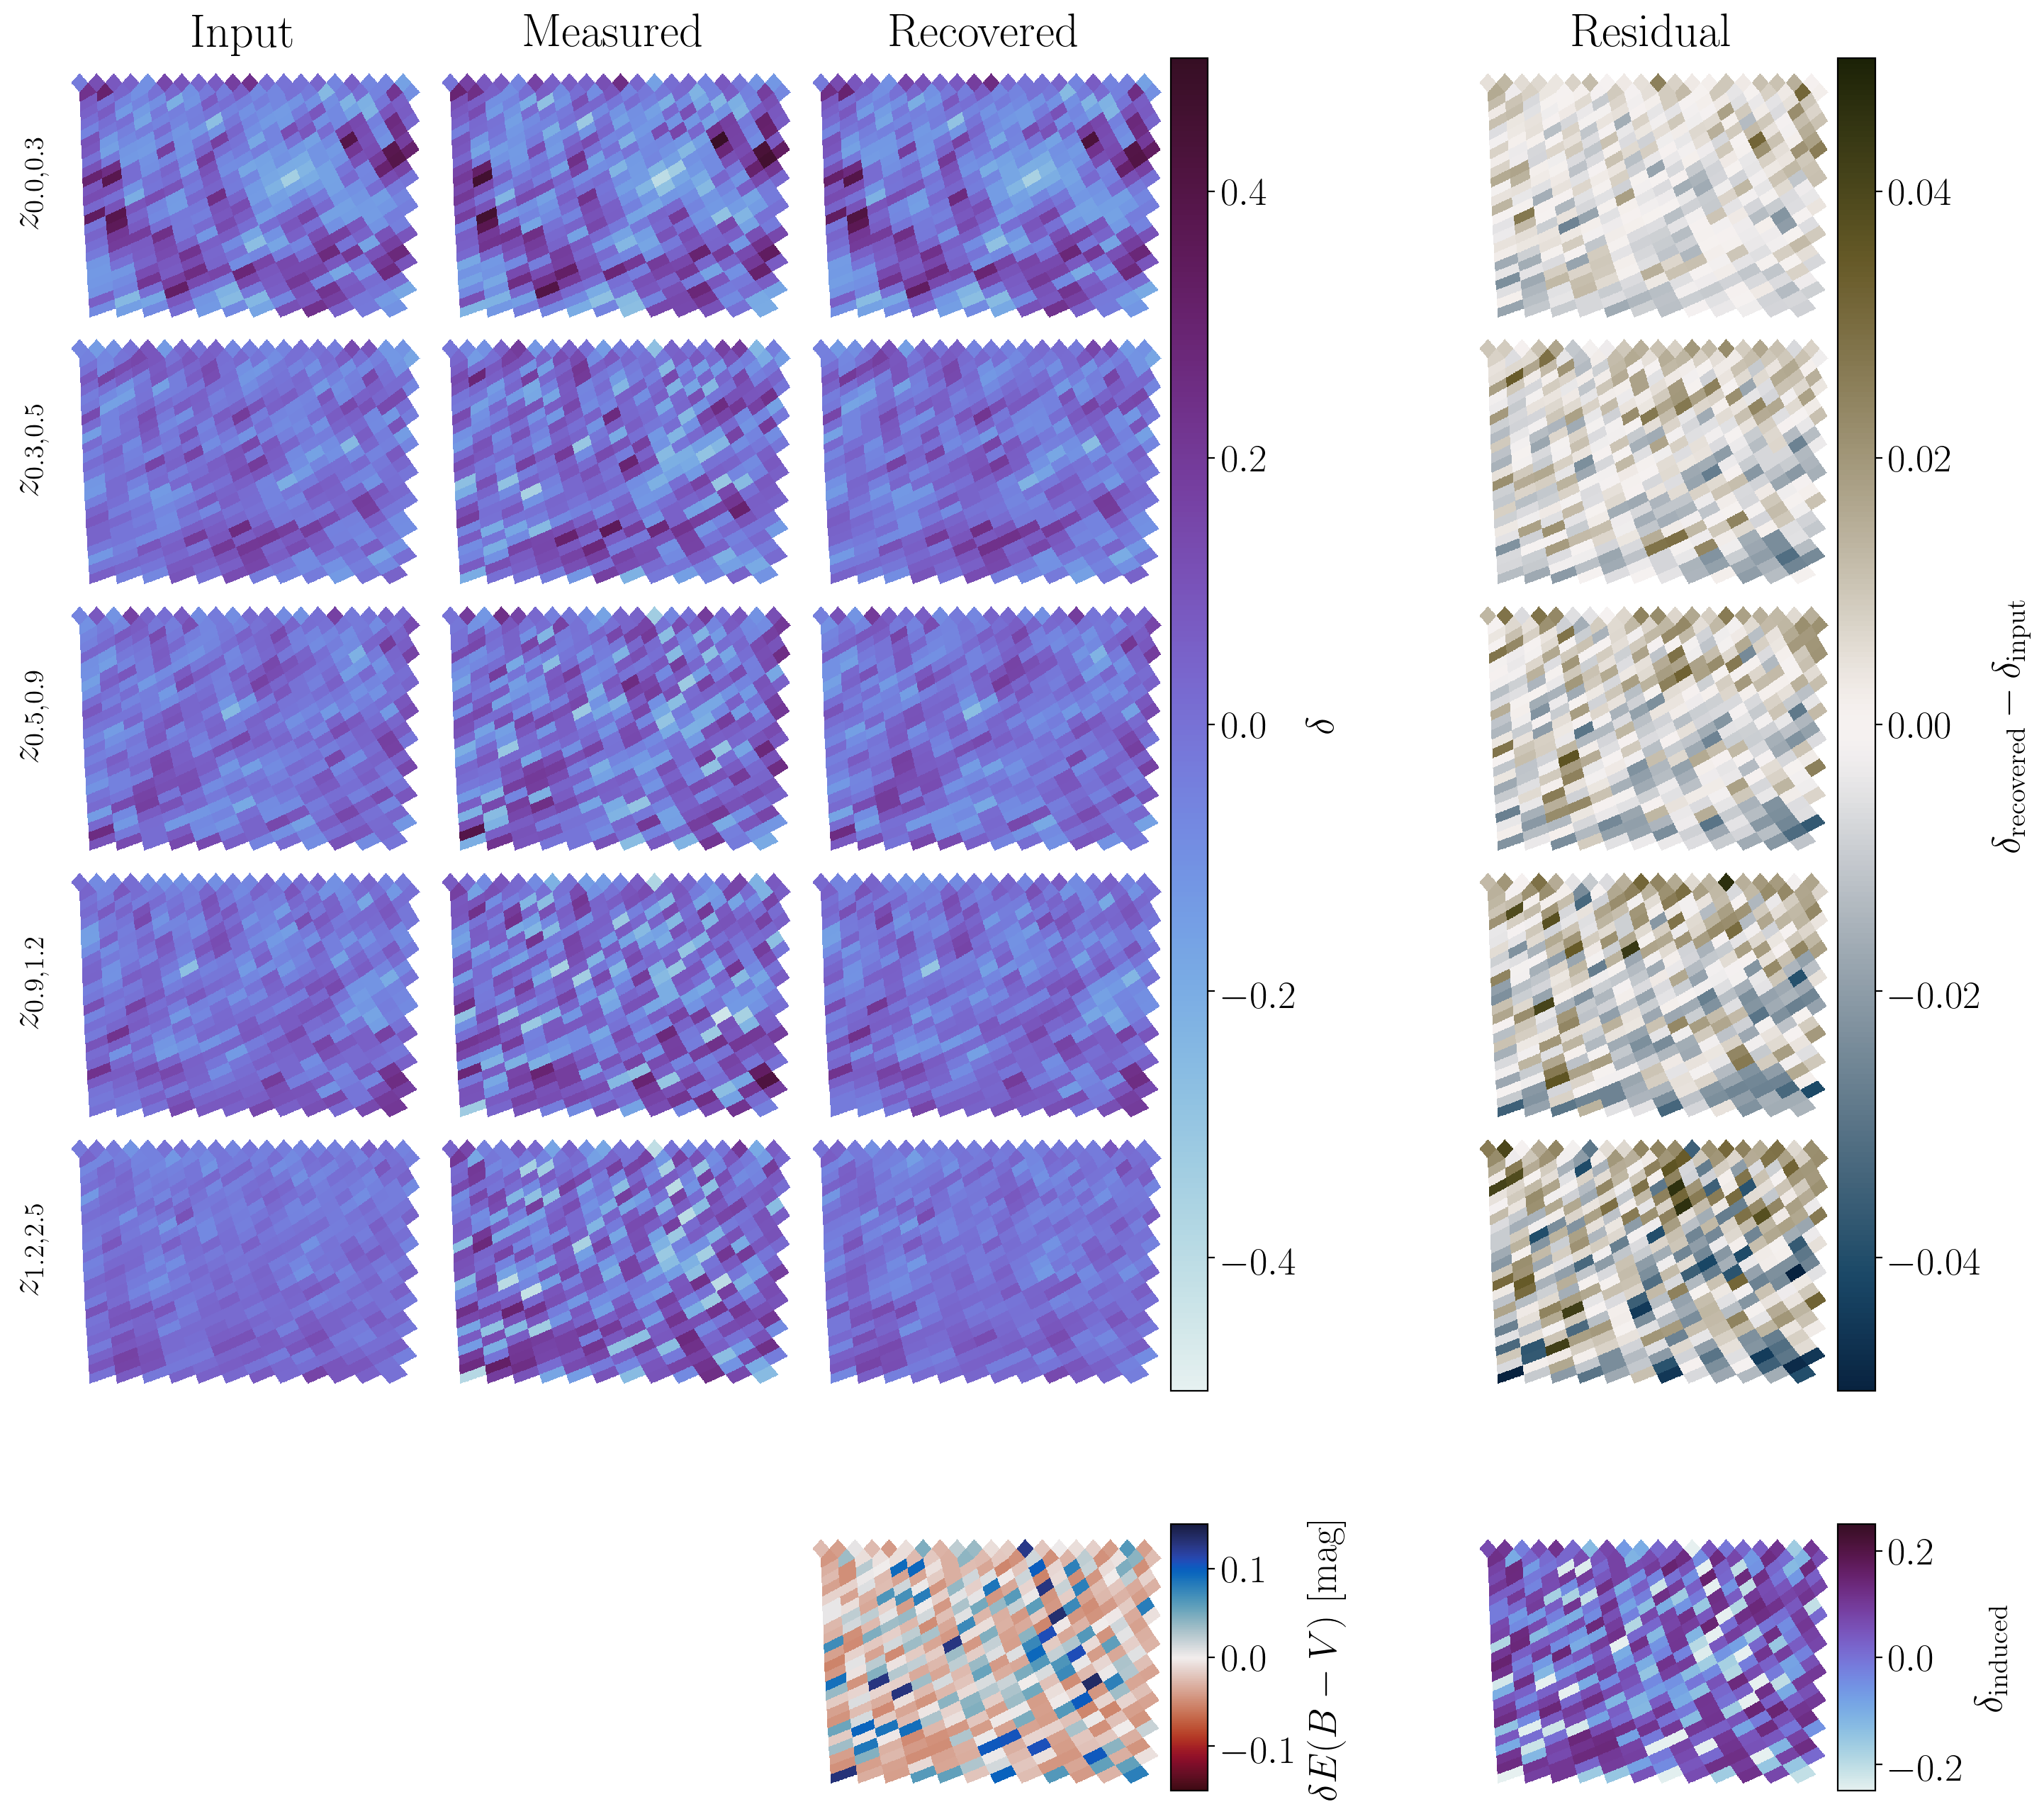

In [100]:
fig=plot.figure(100,figsize=(14.4,13))
spec=gs.GridSpec(nrows=65,ncols=50,figure=fig,wspace=0,hspace=0,left=0.012,right=0.92,bottom=0.02,top=0.96)
fax=[[fig.add_subplot(spec[:10,1:11]),fig.add_subplot(spec[:10,11:21]),fig.add_subplot(spec[:10,21:31]),fig.add_subplot(spec[:10,39:49])],
     [fig.add_subplot(spec[10:20,1:11]),fig.add_subplot(spec[10:20,11:21]),fig.add_subplot(spec[10:20,21:31]),fig.add_subplot(spec[10:20,39:49])],
     [fig.add_subplot(spec[20:30,1:11]),fig.add_subplot(spec[20:30,11:21]),fig.add_subplot(spec[20:30,21:31]),fig.add_subplot(spec[20:30,39:49])],
     [fig.add_subplot(spec[30:40,1:11]),fig.add_subplot(spec[30:40,11:21]),fig.add_subplot(spec[30:40,21:31]),fig.add_subplot(spec[30:40,39:49])],
     [fig.add_subplot(spec[40:50,1:11]),fig.add_subplot(spec[40:50,11:21]),fig.add_subplot(spec[40:50,21:31]),fig.add_subplot(spec[40:50,39:49])],
     [fig.add_subplot(spec[55:65,21:31]),fig.add_subplot(spec[55:65,39:49])]]
cbar_1=fig.add_subplot(spec[:50,31])
cbar_2=fig.add_subplot(spec[:50,49])
cbar_3=fig.add_subplot(spec[55:,31])
cbar_4=fig.add_subplot(spec[55:,49])
ylabels=[fig.add_subplot(spec[:10,0],frame_on=False),fig.add_subplot(spec[10:20,0],frame_on=False),fig.add_subplot(spec[20:30,0],frame_on=False),
         fig.add_subplot(spec[30:40,0],frame_on=False),fig.add_subplot(spec[40:50,0],frame_on=False),fig.add_subplot(spec[55:,0],frame_on=False)]
for i in range(6):
    for j in range(4):
        if i<5 or j<2:
            temp=fax[i][j].get_xaxis().set_ticklabels([])
            temp=fax[i][j].get_yaxis().set_ticklabels([])
for y in ylabels:
    temp=y.get_xaxis().set_ticks([])
    temp=y.get_yaxis().set_ticks([])

# z015
plot.sca(fax[0][0])
hp.cartview(delta_input_Buz_r260_n6['z015'],fig=100,lonra=[60,90],latra=[-61,-39],title='Input',
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[0][1])
hp.cartview(delta_measured_Buz_r260_n6['z015'],fig=100,lonra=[60,90],latra=[-61,-39],title='Measured',
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[0][2])
hp.cartview(delta_recovered_Buz_r260_n6['z015'],fig=100,lonra=[60,90],latra=[-61,-39],title='Recovered',
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[0][3])
hp.cartview(delta_recovered_Buz_r260_n6['z015']-delta_input_Buz_r260_n6['z015'],fig=100,lonra=[60,90],latra=[-61,-39],
            title='Residual',cbar=False,min=-0.05,max=0.05,cmap=cmo.cm.diff,badcolor='white',hold=True)

# z045
plot.sca(fax[1][0])
hp.cartview(delta_input_Buz_r260_n6['z045'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[1][1])
hp.cartview(delta_measured_Buz_r260_n6['z045'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[1][2])
hp.cartview(delta_recovered_Buz_r260_n6['z045'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[1][3])
hp.cartview(delta_recovered_Buz_r260_n6['z045']-delta_input_Buz_r260_n6['z045'],fig=100,lonra=[60,90],title=None,
            latra=[-61,-39],cbar=False,min=-0.05,max=0.05,cmap=cmo.cm.diff,badcolor='white',hold=True)

# z075
plot.sca(fax[2][0])
hp.cartview(delta_input_Buz_r260_n6['z075'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[2][1])
hp.cartview(delta_measured_Buz_r260_n6['z075'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[2][2])
hp.cartview(delta_recovered_Buz_r260_n6['z075'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[2][3])
hp.cartview(delta_recovered_Buz_r260_n6['z075']-delta_input_Buz_r260_n6['z075'],fig=100,lonra=[60,90],title=None,
            latra=[-61,-39],cbar=False,min=-0.05,max=0.05,cmap=cmo.cm.diff,badcolor='white',hold=True)

# z105
plot.sca(fax[3][0])
hp.cartview(delta_input_Buz_r260_n6['z105'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[3][1])
hp.cartview(delta_measured_Buz_r260_n6['z105'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[3][2])
hp.cartview(delta_recovered_Buz_r260_n6['z105'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[3][3])
hp.cartview(delta_recovered_Buz_r260_n6['z105']-delta_input_Buz_r260_n6['z105'],fig=100,lonra=[60,90],title=None,
            latra=[-61,-39],cbar=False,min=-0.05,max=0.05,cmap=cmo.cm.diff,badcolor='white',hold=True)

# z185
plot.sca(fax[4][0])
hp.cartview(delta_input_Buz_r260_n6['z185'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[4][1])
hp.cartview(delta_measured_Buz_r260_n6['z185'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[4][2])
hp.cartview(delta_recovered_Buz_r260_n6['z185'],fig=100,lonra=[60,90],latra=[-61,-39],title=None,
            cbar=False,min=-0.5,max=0.5,cmap=cmo.cm.dense,badcolor='white',hold=True)
plot.sca(fax[4][3])
hp.cartview(delta_recovered_Buz_r260_n6['z185']-delta_input_Buz_r260_n6['z185'],fig=100,lonra=[60,90],title=None,
            latra=[-61,-39],cbar=False,min=-0.05,max=0.05,cmap=cmo.cm.diff,badcolor='white',hold=True)

# induced
plot.sca(fax[5][0])
hp.cartview(SFD_Buz_r260_n6-np.nanmean(SFD_Buz_r260_n6),fig=100,lonra=[60,90],latra=[-61,-39],cbar=None,title=None,
            min=-0.15,max=0.15,cmap=cmo.cm.balance_r,badcolor='white',hold=True)
plot.sca(fax[5][1])
hp.cartview(induced_delta,fig=100,lonra=[60,90],latra=[-61,-39],cbar=None,title=None,badcolor='white',
            min=-0.25,max=0.25,cmap=cmo.cm.dense,hold=True)

ylabels[0].text(-0.2,0.4,'$z_{0.0,0.3}$',rotation=90)
ylabels[1].text(-0.2,0.4,'$z_{0.3,0.5}$',rotation=90)
ylabels[2].text(-0.2,0.4,'$z_{0.5,0.9}$',rotation=90)
ylabels[3].text(-0.2,0.4,'$z_{0.9,1.2}$',rotation=90)
ylabels[4].text(-0.2,0.4,'$z_{1.2,2.5}$',rotation=90)

cbar1=plot.colorbar(cax=cbar_1,mappable=cm.ScalarMappable(norm=col.Normalize(vmin=-0.5,vmax=0.5),cmap=cmo.cm.dense))
cbar1.set_label('$\delta$')
cbar2=plot.colorbar(cax=cbar_2,mappable=cm.ScalarMappable(norm=col.Normalize(vmin=-0.05,vmax=0.05),cmap=cmo.cm.diff))
cbar2.set_label('$\delta_\mathrm{recovered}-\delta_\mathrm{input}$')
cbar3=plot.colorbar(cax=cbar_3,mappable=cm.ScalarMappable(norm=col.Normalize(vmin=-0.15,vmax=0.15),cmap=cmo.cm.balance_r))
cbar3.set_label('$\delta E(B-V)$ [mag]')
cbar4=plot.colorbar(cax=cbar_4,mappable=cm.ScalarMappable(norm=col.Normalize(vmin=-0.25,vmax=0.25),cmap=cmo.cm.dense))
cbar4.set_label('$\delta_\mathrm{induced}$')

plot.savefig('../MWdust_results/delta_map_B260_n6.pdf')
plot.savefig('../MWdust_results/PNG/delta_map_B260_n6.png')
plot.show()